In [13]:
%matplotlib inline
import json
import math
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, expon, gamma, norm, pearsonr
from itertools import groupby, cycle
from operator import itemgetter
from sklearn import metrics
from IPython.display import Markdown, display
import ipywidgets
mpl.rcParams['figure.dpi'] = 300

In [3]:
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.latex.repr', True)
# pd.set_option('display.latex.longtable', True)

# CAID
## Dataset
Critical Assessment of Intrinsic Disorder (CAID) is a continuous experiment where prediction methods for intrinsic disorder (ID) are blind tested on unpublished DisProt data.

In [4]:
reference_path = '/home/marnec/Projects/CAID/caid/data/binding/'
prediction_path = '/home/marnec/Projects/CAID/caid/data/results/'
baseline_dir = '/home/marnec/Projects/CAID/caid/baseline'
results_dir = '/home/marnec/Projects/CAID/caid/results'
labels_path = '/home/marnec/Projects/CAID/caid/caid/'

ref_widget = ipywidgets.RadioButtons(
    options={r.split('_')[0]
             for r in os.listdir(reference_path)},
    description="Reference:",
    disabled=False,
    value='new-disprot-binding')

neg_widget = ipywidgets.RadioButtons(options={
    r.split('_')[1].split('.')[0]
    for r in os.listdir(reference_path)
},
                                     description="Reference:",
                                     disabled=False,
                                     value='simple')

opt_widget = ipywidgets.RadioButtons(options=['Default', 'ROC', 'Fmax'],
                                     description="Reference:",
                                     disabled=False,
                                     value='Default')

accordion = ipywidgets.Accordion(children=[ref_widget, neg_widget, opt_widget])
accordion.set_title(0, 'Reference')
accordion.set_title(1, 'Negatives')
accordion.set_title(2, 'Threshold optimization')
accordion

Accordion(children=(RadioButtons(description='Reference:', options=('new-disprot-binding',), value='new-dispro…

In [5]:
reference = ref_widget.value
negatives = neg_widget.value
thr_optimization = opt_widget.value
reference_fullpath = os.path.join(reference_path,
                                  "{}_{}.txt".format(reference, negatives))

labels_codes = json.load(open(labels_path + "caid_codes.json"))
labels_names = json.load(open(labels_path + "caid_names.json"))

labels_codes_f = lambda k: labels_codes.get(k, k)
labels_names_f = lambda k: labels_names.get(k, k)

In [6]:
def get_ref_dict(ref_file):
    """Load reference in dict. Disprot are used as keys"""
    ref = {}
    with open(ref_file) as f:
        faiter = (x[1] for x in groupby(f, lambda line: line[0] == ">"))
        for header in faiter:
            header = next(header)
            if header[0] != '#':
                acc, *desc = header[1:].strip().split()
                seq, states = map(str.strip, next(faiter))
                nastates = np.fromiter(map({
                    '0': 0,
                    '1': 1,
                    '-': np.nan
                }.get, states),
                                       dtype=float)
                ref[acc] = {'seq': seq, 'states': nastates}
    return ref

In [7]:
# load reference
refdict = get_ref_dict(reference_fullpath)

<br>

Current analysis is performed on the **new-disprot-binding** dataset with **simple** 
negative definition. This means that DisProt defines order for *new-disprot-binding* and *the contrary of DisProt 
defines order*.

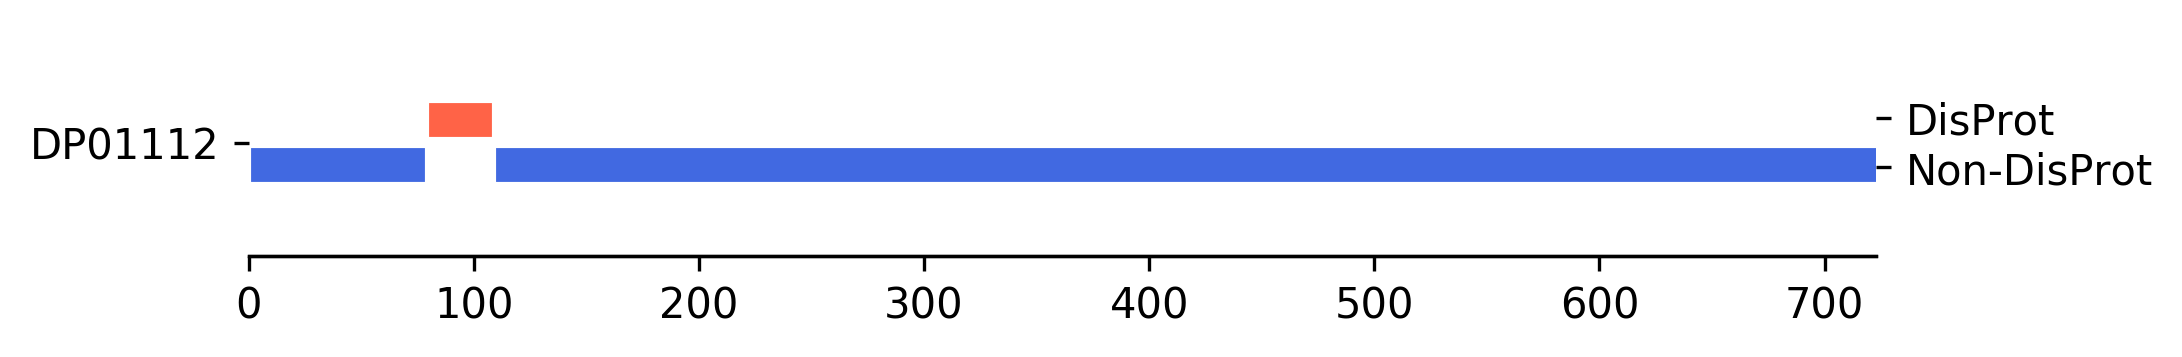

In [14]:
disprot_entry = 'DP01112'


def get_regs(sequence):
    statusdict = {0: 'order', 1: 'disorder', np.nan: 'undefined'}
    regions = list()
    for status, groups in groupby(enumerate(sequence), key=itemgetter(1)):
        groups = list(groups)
        start = groups[0][0]
        end = groups[-1][0]
        if not np.isnan(status):
            regions.append([start, end, end - start + 1, statusdict[status]])

    return regions


def plot_entry(disprot_entry, negs):
    regs = get_regs(refdict[disprot_entry]['states'])
    fig, ax = plt.subplots(figsize=(7, 1))
    ax.set_ylim(0.2, 0.8)
    ax.set_xlim(0, regs[-1][1])
    cmap = {'disorder': 'tomato', 'order': 'royalblue'}
    hmap = {'disorder': 0.56, 'order': 0.44}
    nmap = {'simple': 'Non-DisProt'}
    colors = list(map(cmap.get, list(zip(*regs))[-1]))
    heights = list(map(hmap.get, list(zip(*regs))[-1]))

    h = 0.1
    plt.barh(heights,
             list(zip(*regs))[2],
             left=list(zip(*regs))[0],
             height=h,
             color=colors,
             linewidth=1,
             edgecolor='w',
             label=list(zip(*regs))[-1])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    twy = ax.twinx()
    twy.spines['right'].set_visible(False)
    twy.spines['top'].set_visible(False)
    twy.spines['left'].set_visible(False)

    ax.set_yticks([0.5])
    ax.set_yticklabels([disprot_entry])
    twy.set_yticks([0.44 - h / 2, 0.56 + h / 2])
    twy.set_yticklabels([nmap.get(negs, negs.upper()), 'DisProt'])


negdefs = {'simple': "the contrary of DisProt"}
refdefs = {'new-disprot-all': "all its new entries"}

display(Markdown("""Current analysis is performed on the **{}** dataset with **{}** 
negative definition. This means that DisProt defines order for *{}* and *{} 
defines order*."""\
.format(reference, negatives, refdefs.get(reference, reference),
        negdefs.get(negatives, negatives))))
plot_entry(disprot_entry, negatives)

In [15]:
sentence = """DisProt merged regions define positive cases (labeled as $1$) in reference states. Remaining states are considered {}.""".format("negatives" if negatives == 'simple' else "undefined")

display(Markdown("""DisProt entries can have annotation covering the same sequence space. In these cases different evidences are merged in a unique continuous region. """ + sentence))

DisProt entries can have annotation covering the same sequence space. In these cases different evidences are merged in a unique continuous region. DisProt merged regions define positive cases (labeled as $1$) in reference states. Remaining states are considered negatives.

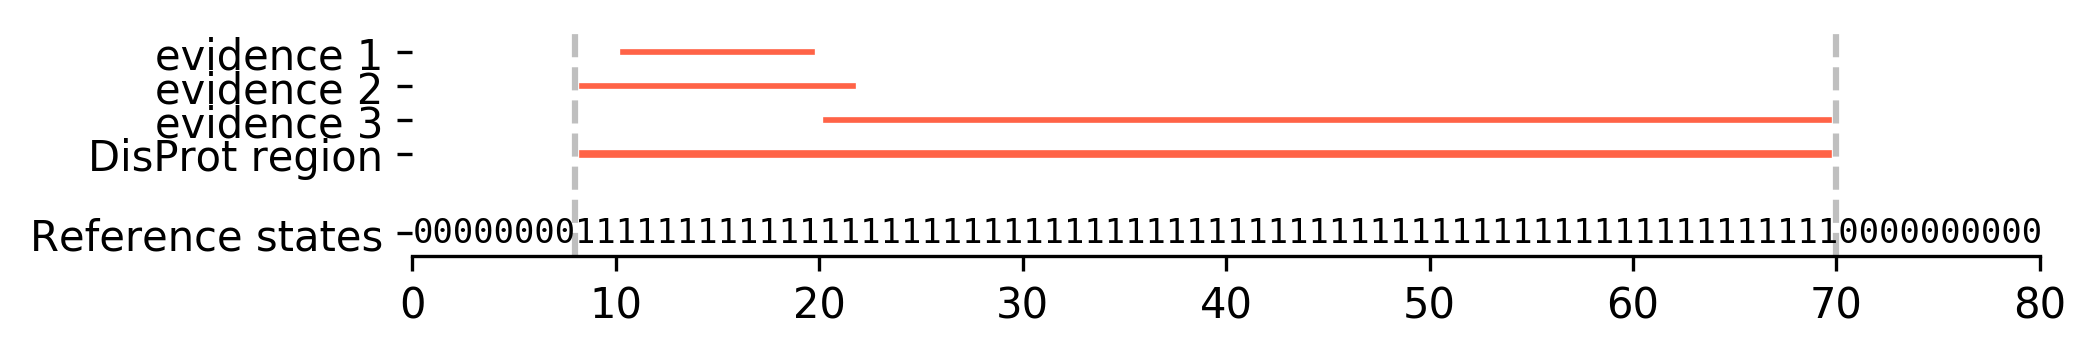

In [16]:
fig, ax = plt.subplots(figsize=(7, 1))
ax.set_ylim(-1.2, 0.8)
ax.set_xlim(0, 80)

ys = np.array([0.6, 0.3, 0.0, -0.3])
hs = np.array([.12, .12, .12, .14])
lbls = ['evidence 1', 'evidence 2', 'evidence 3', 'DisProt region']

ax.barh(ys, [10, 14, 50, 62], left=[10, 8, 20, 8], height=hs, linewidth=2, edgecolor='w', facecolor='tomato');

if negatives != 'simple':
    ax.barh(-0.6, 15, left=65, height=.12, facecolor='royalblue')
    ys = np.append(ys, -0.6)
    lbls.append(negatives)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.axvline(8, c='grey', alpha=0.5, linestyle='--')
ax.axvline(70, c='grey', alpha=0.5, linestyle='--')

neg_char = '0' if negatives == 'simple' else '-'
ax.text(0, -1, neg_char * 8 + '1' * 62 + '0' * 10, fontsize=8.1, verticalalignment='center', family='monospace')
lbls.append('Reference states')

ax.set_yticks(np.append(ys, -1))
ax.set_yticklabels(lbls);

In [17]:
def get_pname(ref, negs, btype=None):
    """Build predictor name from parameters"""
    pname = [ref, negs]
    if btype is not None:
        pname.append(btype)
    return '_'.join(pname)


def get_fname(ref, negs, rdir, rtype, btype=None):
    """Get prediction filename from parameter"""
    ext = '.txt' if rtype in ('rocPoints', 'prcPoints') else '.csv'
    fname = [get_pname(ref, negs, btype), rtype]
    return os.path.join(rdir, '_'.join(fname) + ext)

In [18]:
def add_auc(df, ref, negs, rdir, curve, baseline=False):
    """Append AUC from a curve file to a DataFrame"""
    btype = 'cons' if baseline is True else None
    curvefile = get_fname(ref, negs, rdir,
                          'rocPoints' if curve is 'roc' else 'prcPoints',
                          btype)

    table = []
    if os.path.isfile(curvefile):
        for columns in parse_curve_file(curvefile):
            table.append(columns[:2])
    else:
        table.append([get_pname(ref, negs, btype), np.nan])

    return pd.concat([
        df,
        pd.DataFrame(table, columns=['pred', 'AUC-{}'.format(curve)
                                     ]).set_index(['pred'])
    ],
                     sort=False,
                     axis=1)

In [19]:
def load_scores_tables(ref, negs, base_dir, res_dir, optimized_thr):
    if optimized_thr != "Default":
        assert optimized_thr in {"ROC", 'Fmax'}
        stype = 'redefScores{}'.format(optimized_thr)
    else:
        stype = 'scores'

    # baselines
    bchunk = pd.read_csv(get_fname(ref, negs, base_dir, 'scores', 'chunk'),
                         index_col=[0]).mean().to_frame().transpose()
    bchain = pd.read_csv(get_fname(ref, negs, base_dir, 'scores', 'chain'),
                         index_col=[0]).mean().to_frame().transpose()

    bln = [bchunk, bchain]
    bln_names = ['chunk', 'chain']


    # predictions
    preds = pd.read_csv(get_fname(ref, negs, res_dir, stype), index_col=[0])

    # merge baselines
    base = pd.concat(bln, axis=0, sort=False)
    base.index = bln_names
    return base, preds


def merge_scores_tables(ref, negs, base_dir, res_dir, optimized_thr):
    """Merge all baselines and predictors' scores"""
    base, preds = load_scores_tables(ref,
                                     negs,
                                     base_dir,
                                     res_dir,
                                     optimized_thr=optimized_thr)
    # merge baselines and predictions
    df = pd.concat([preds, base], sort=False).round(3)
    df[["TP", "FN", "TN", "FP", "npred",
        "nref"]] = df[["TP", "FN", "TN", "FP", "npred", "nref"]].astype(np.float)
    return df

In [20]:
def load_target_tables(ref, negs, base_dir, res_dir, optimized_thr):
    if optimized_thr != "Default":
        assert optimized_thr in {"ROC", 'Fmax'}
        stype = 'redefScores{}'.format(optimized_thr)
    else:
        stype = 'scores'

    stype = 'perInstanceRedefScores' if optimized_thr is True else 'perInstanceScores'
    # baselines
    bchunk = pd.read_csv(get_fname(ref, negs, base_dir, 'perInstanceScores',
                                   'chunk'),
                         index_col=[0, 1],
                         header=[0]).groupby(level=1).mean()
    bchunk = bchunk.set_index([['random_chunk'] * len(bchunk), bchunk.index])

    bchain = pd.read_csv(get_fname(ref, negs, base_dir, 'perInstanceScores',
                                   'chain'),
                         index_col=[0, 1],
                         header=[0]).groupby(level=1).mean()
    bchain = bchain.set_index([['random_chain'] * len(bchain), bchain.index])
    bln = [bchunk, bchain]
    # predictions
    preds = pd.read_csv(get_fname(ref, negs, res_dir, stype),
                        index_col=[0, 1],
                        header=[0])
    # merge baselines
    base = pd.concat(bln, axis=0, sort=False)

    return base, preds


def merge_targets_tables(ref, negs, base_dir, res_dir, optimized_thr):
    """Merge all baselines and predictors' scores"""
    base, preds = load_target_tables(ref,
                                     negs,
                                     base_dir,

                                     res_dir,
                                     optimized_thr=optimized_thr)
    # merge all

    return pd.concat([preds, base], axis=0, sort=False).round(3)

In [21]:
def parse_curve_file(curve_file, parse_code=None):
    """Parse ROC and PRC files"""
    with open(curve_file) as f:
        for line in f:
            code, _, auc, *points = line.split()
            auc = float(auc)
            x, y, thr = zip(*map(lambda s: map(float, s.split(',')), points))

            if parse_code is not None and callable(parse_code):
                code = parse_code(code)

            yield code, auc, np.array(x), np.array(y), np.array(thr)


def merge_curves(curve_type):
    curve_type += 'Points'
    parse_naive = lambda c: 'naive-' + c.split('-')[-1]
    preds = list(
        parse_curve_file(
            get_fname(reference, negatives, results_dir, curve_type)))

    return preds, []

In [22]:
def load_predstack(fname):
    with open(fname) as f:
        targets = {}
        preds = {}
        for line in f:
            line = line.strip()
            if line[0] == '#':
                target_positions = line[1:].split("#")
                for position in target_positions:
                    target, start, end = position.split(",")
                    targets[target] = (int(start), int(end))
            else:
                method, pred = line.split()
                preds[method] = np.fromiter(map(int, pred), dtype=np.float)

    return targets, preds


def merge_predstacks(fname):
    pass

In [23]:
# build score table (may take a while)
scores = merge_scores_tables(reference, negatives, baseline_dir, results_dir, thr_optimization)

In [24]:
# build target-wise score table
target_scores = merge_targets_tables(reference, negatives, baseline_dir, results_dir, thr_optimization)

In [25]:
rocs, rocs_base = merge_curves('roc')
prcs, prcs_base = merge_curves('prc')

## Evaluation metrics

In [26]:
sortby = "BAc"
display(
    Markdown("""
Metrics evaluating prediction scores are calculated applying **{}** thresholds to prediction scores.
Table is sorted by descending value of {} column
""".format(thr_optimization, sortby)))


Metrics evaluating prediction scores are calculated applying **ROC** thresholds to prediction scores.
Table is sorted by descending value of BAc column


In [27]:
scores.sort_values(by="BAc", ascending=False).drop(["F1s_n", "Pre_n", "FPR"], axis=1).rename(index=labels_names)

FN        FP         TN        TP    BAc    F1s  \
*OPAL                   6746.00  36395.00   68407.00  14450.00  0.667  0.401   
DisoRDPbind-protein     4710.00  47966.00   57306.00  16753.00  0.662  0.389   
ANCHOR-2                6071.00  41847.00   63425.00  15392.00  0.660  0.391   
MoRFchibi-light         6519.00  40608.00   64194.00  14677.00  0.652  0.384   
chunk                  12418.41  12418.41   92853.59   9044.59  0.652  0.421   
*MoRFchibi-web          7632.00  37449.00   67353.00  13564.00  0.641  0.376   
ANCHOR                  5241.00  54578.00   50694.00  16222.00  0.619  0.352   
*DISOPRED-3.1-binding  15753.00  11232.00   94040.00   5710.00  0.580  0.297   
fMoRFpred              16688.00  17174.00   88098.00   4775.00  0.530  0.220   
DisoRDPbind-DNA        16082.00  21703.00   83569.00   5381.00  0.522  0.222   
DisoRDPbind-RNA        21041.00   1488.00  103784.00    422.00  0.503  0.036   
chain                  17829.00  17829.00   87443.00   3634.00  0.500  0.169   

                         MCC    Pre    Rec  Rec_n  AUC_PRC  AUC_ROC  npred  \
*OPAL                  0.255  0.284  0.682  0.653    0.348    0.717  232.0   
DisoRDPbind-protein    0.244  0.259  0.781  0.544    0.265    0.689  233.0   
ANCHOR-2               0.241  0.269  0.717  0.602    0.278    0.701  233.0   
MoRFchibi-light        0.230  0.265  0.692  0.613    0.359    0.718  232.0   
chunk                  0.303  0.421  0.421  0.882      NaN      NaN  100.0   
*MoRFchibi-web         0.215  0.266  0.640  0.643    0.335    0.703  232.0   
ANCHOR                 0.179  0.229  0.756  0.482    0.250    0.653  233.0   
*DISOPRED-3.1-binding  0.176  0.337  0.266  0.893    0.274    0.579  233.0   
fMoRFpred              0.059  0.218  0.222  0.837    0.208    0.546  233.0   
DisoRDPbind-DNA        0.041  0.199  0.251  0.794    0.197    0.521  233.0   
DisoRDPbind-RNA        0.017  0.221  0.020  0.986    0.150    0.425  233.0   
chain                 -0.000  0.169  0.169  0.831      NaN      NaN  100.0   

                        nref  
*OPAL                  233.0  
DisoRDPbind-protein    233.0  
ANCHOR-2               233.0  
MoRFchibi-light        233.0  
chunk                  100.0  
*MoRFchibi-web         233.0  
ANCHOR                 233.0  
*DISOPRED-3.1-binding  233.0  
fMoRFpred              233.0  
DisoRDPbind-DNA        233.0  
DisoRDPbind-RNA        233.0  
chain                  100.0

Where table column names mean:

| label | meaning |
|---|---|
| BAc  | balanced accuracy  |
| F1s  | F1-score  |
| MCC  | Matthew's Correlation Coefficient  |
| Pre  | Precision/Selectivity  |
| Rec  | Recall/Sensitivity  |
| Rec_n  | Specificity  |
| AUC_ROC  | Area under the ROC curve  |
| AUC_PRC  | Area under the PR curve  |
| npred  | number of predicted targets  |
| nref  | number of targets in reference  |


### Balanced accuracy
Comparison of predictors and baselines performance by balanced accuracy.

In [28]:
# load base and predictors scores (per-residue)
b, p = load_scores_tables(reference, negatives, baseline_dir, results_dir,
                          thr_optimization)
# load base and predictors scores (per-target)
bt, pt = load_target_tables(reference, negatives, baseline_dir, results_dir,
                            thr_optimization)

set()


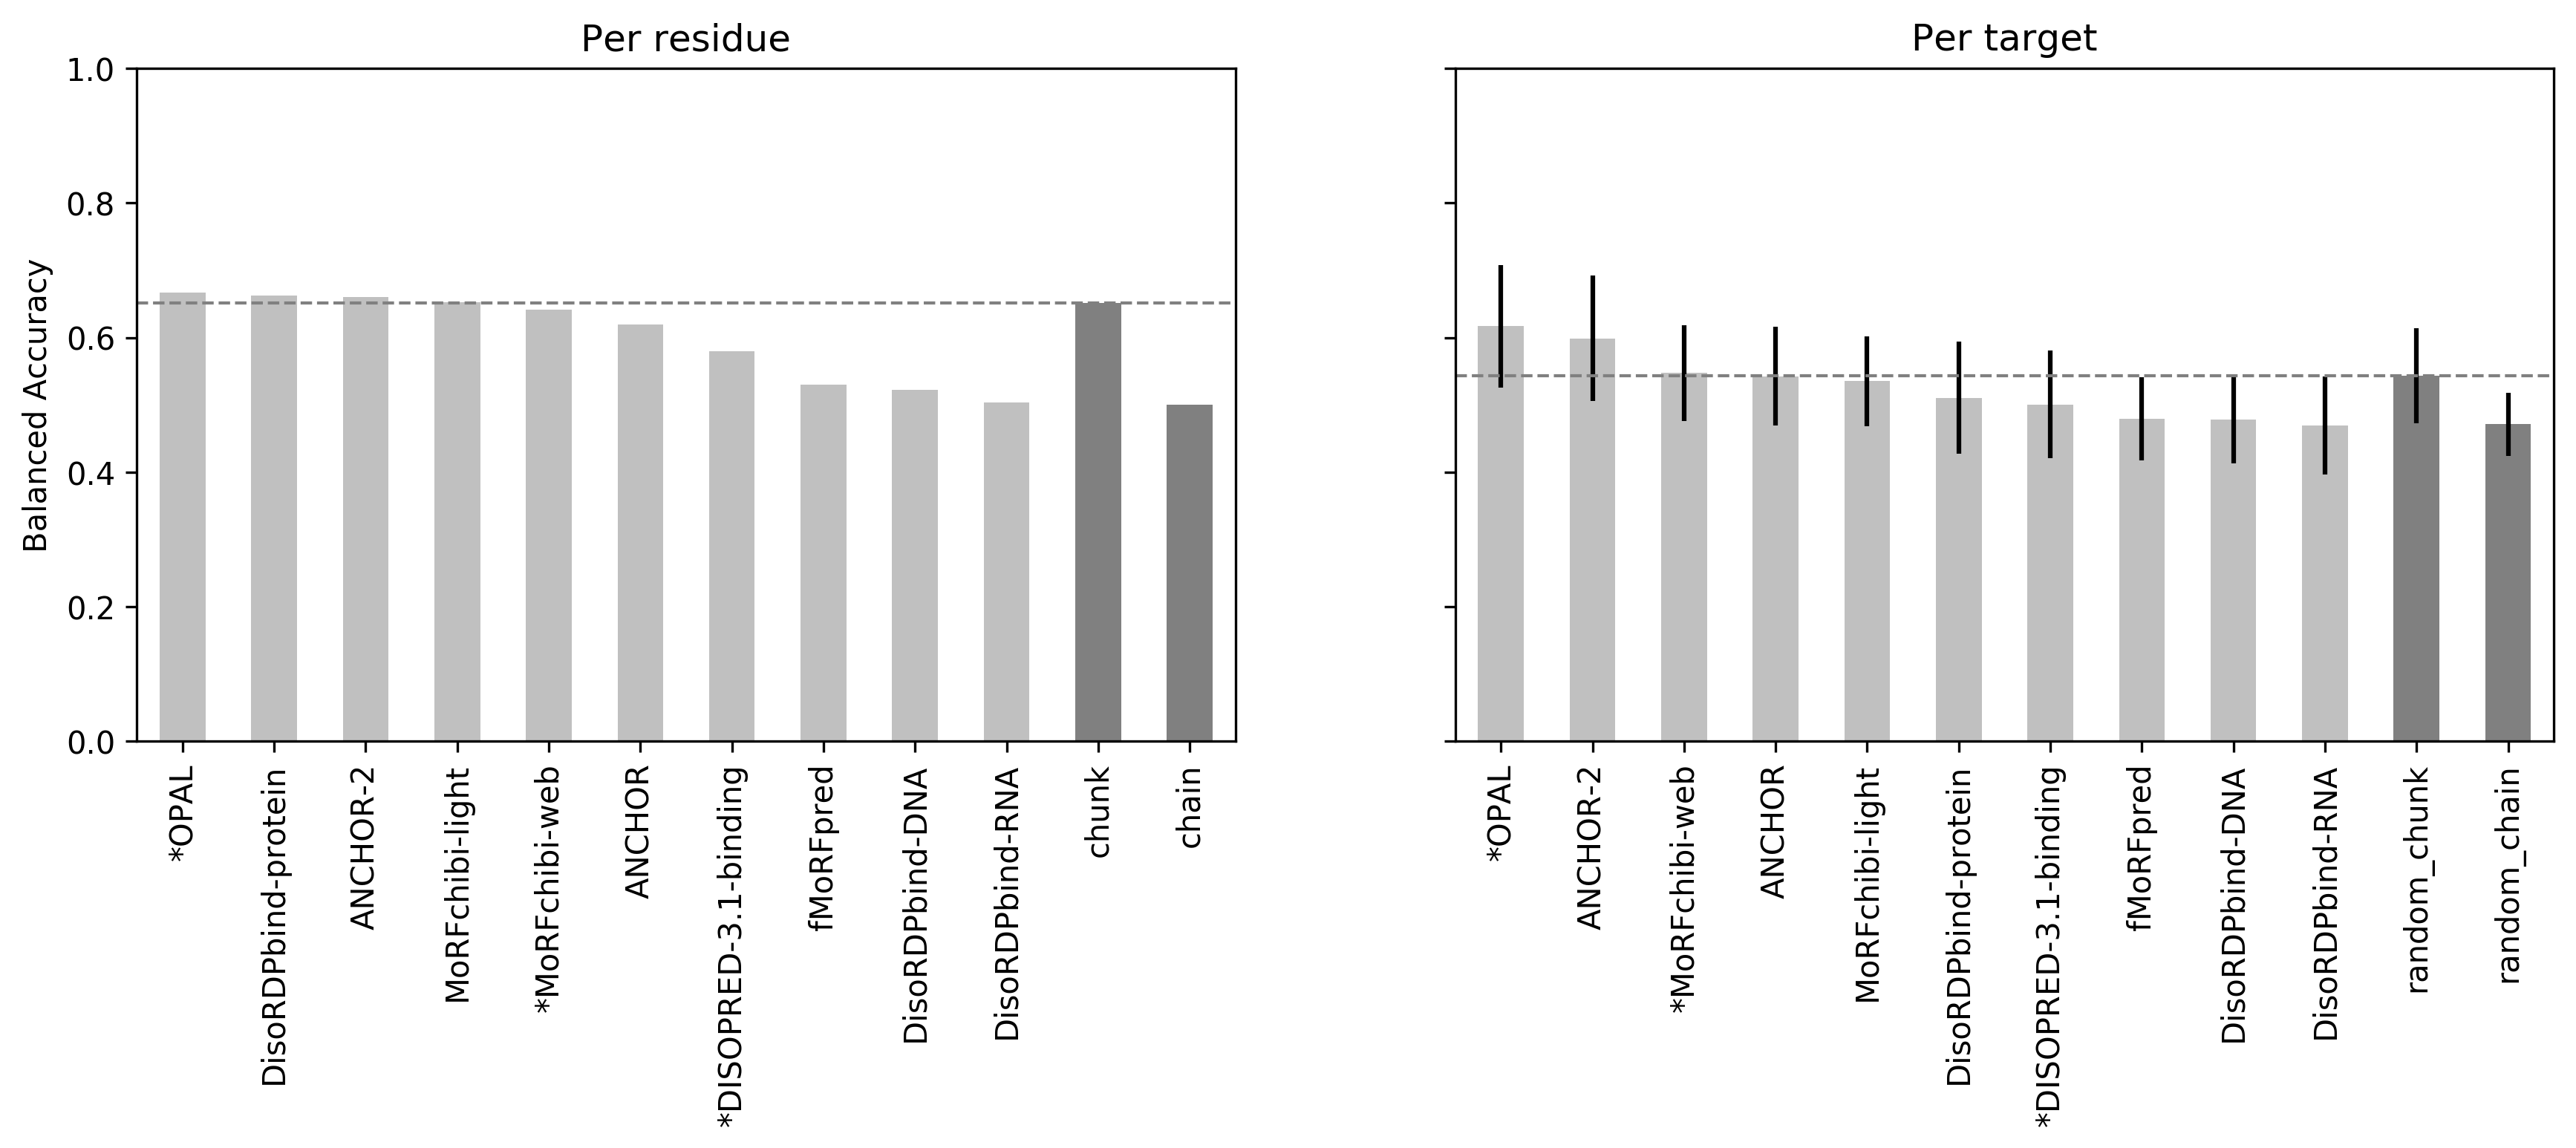

In [37]:
bt_acc_mean, bt_acc_std = bt.xs('bal_acc', level=1).mean(axis=1), bt.xs(
    'bal_acc', level=1).std(axis=1)
pt_acc_mean, pt_acc_std = pt.xs('bal_acc', level=1).mean(axis=1), pt.xs(
    'bal_acc', level=1).std(axis=1)
pt_acc_mean.drop('B007_DisoRDPbind', inplace=True)
b_acc = b["BAc"]
p_acc = p["BAc"]

# init figure
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
# set different colors for prediction and baselines
colors = ['silver'] * len(p_acc) + ['grey'] * len(b_acc)
# draw per-residue bars
p_acc.sort_values(ascending=False).rename(index=labels_names).append(
    b_acc.sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])
axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_ylim(0, 1)
axes[0].set_title('Per residue')
# draw horizontal line at maximum baseline
axes[0].axhline(b_acc.max(), linestyle='--', color='grey', linewidth=1)
# draw mean per-target bars
acc_mean = pt_acc_mean.sort_values(ascending=False).rename(index=labels_names).append(
    bt_acc_mean.sort_values(ascending=False))
# order std with the same order as mean
acc_std = pt_acc_std.rename(index=labels_names).append(bt_acc_std).loc[acc_mean.index]
# plot bars with error
acc_mean.plot.bar(color=colors, ax=axes[1], yerr=acc_std / 2)
# draw horizontal line at maximum baseline
axes[1].axhline(bt_acc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_ylabel('Balanced Accuracy')
axes[1].set_title('Per target');

Overall (left panel) and average per-target (right panel) balanced accuracy. Light gray bars represent published prediction methods; dark gray bars represent baseline prediction methods. On the right panel standard deviation is shown as an error bar.

### F1-score
Comparison of predictors and baselines performance by F1-score.

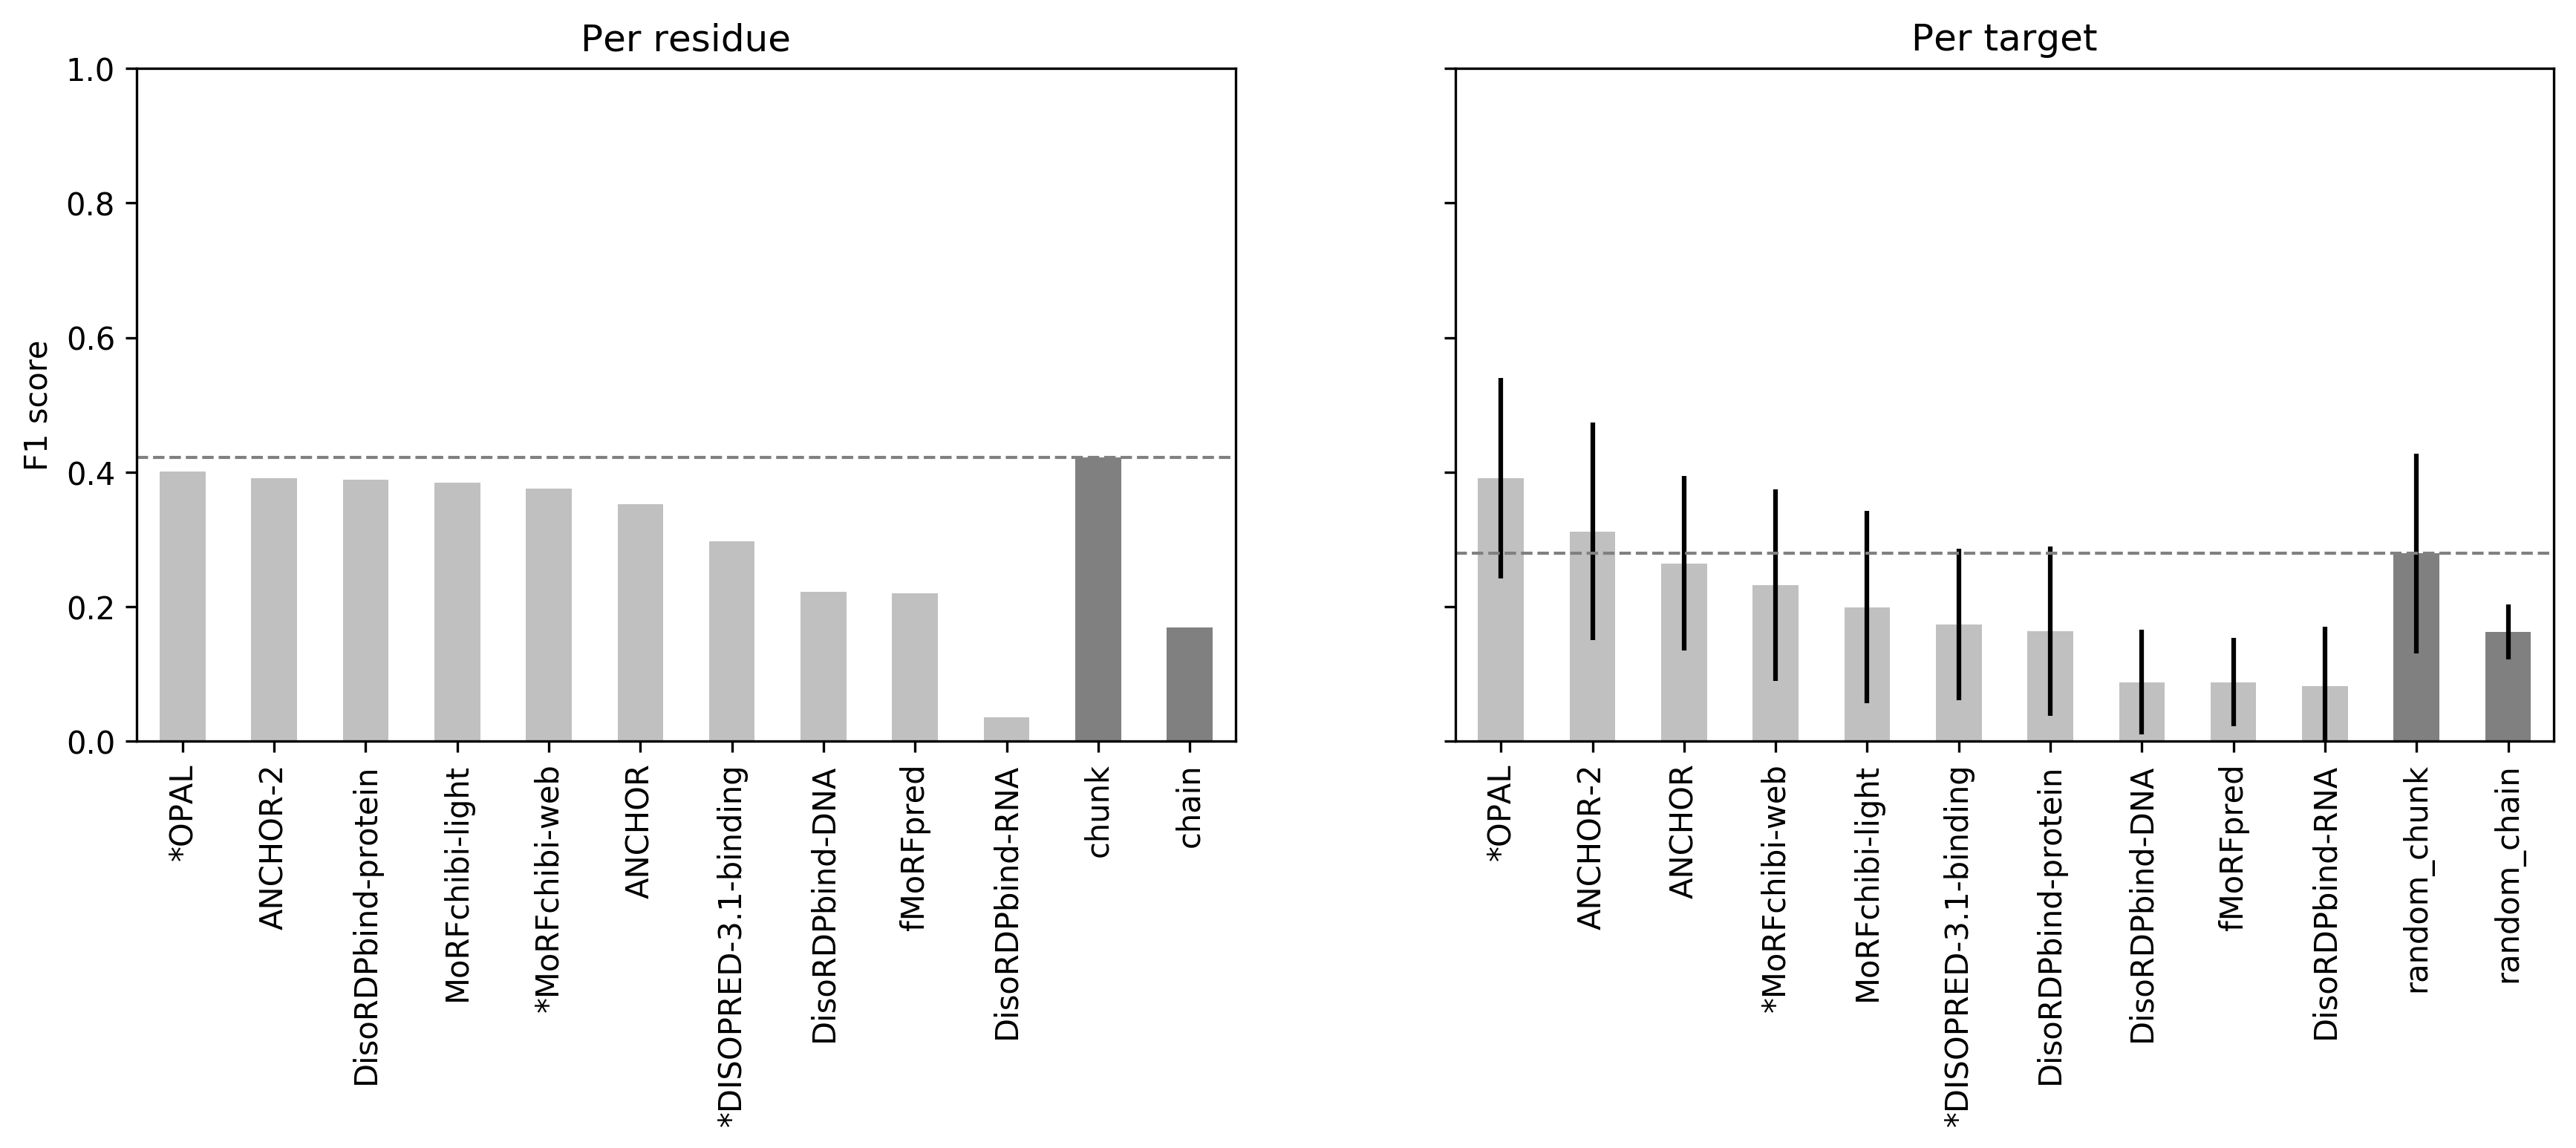

In [38]:
bt_f1s_mean, bt_f1s_std = bt.xs('fscore', level=1).mean(axis=1), bt.xs(
    'fscore', level=1).std(axis=1)
pt_f1s_mean, pt_f1s_std = pt.xs('fscore', level=1).mean(axis=1), pt.xs(
    'fscore', level=1).std(axis=1)
pt_f1s_mean.drop('B007_DisoRDPbind', inplace=True)
# init figure
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
# set different colors for prediction and baselines
colors = ['silver'] * len(p) + ['grey'] * len(b)
# draw per-residue bars
p['F1s'].sort_values(ascending=False).rename(index=labels_names).append(
    b['F1s'].sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])
axes[0].set_ylabel('F1 score')
axes[0].set_ylim(0, 1)
axes[0].set_title('Per residue')
# draw horizontal line at maximum baseline
axes[0].axhline(b['F1s'].max(), linestyle='--', color='grey', linewidth=1)
# draw mean per-target bars
f1s_mean = pt_f1s_mean.sort_values(ascending=False).rename(index=labels_names).append(
    bt_f1s_mean.sort_values(ascending=False))
# order std with the same order as mean
f1s_std = pt_f1s_std.rename(index=labels_names).append(bt_f1s_std).loc[f1s_mean.index]
# plot bars with error
f1s_mean.plot.bar(color=colors, ax=axes[1], yerr=f1s_std / 2)
# draw horizontal line at maximum baseline
axes[1].axhline(bt_f1s_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_ylabel('F1 score')
axes[1].set_title('Per target');

Overall (left panel) and average per-target (right panel) F1-score. Light gray bars represent published prediction methods; dark gray bars represent baseline prediction methods. On the right panel standard deviation is shown as an error bar.

### MCC
Comparison of predictors and baselines performance by Matthew's Correlation Coefficient.

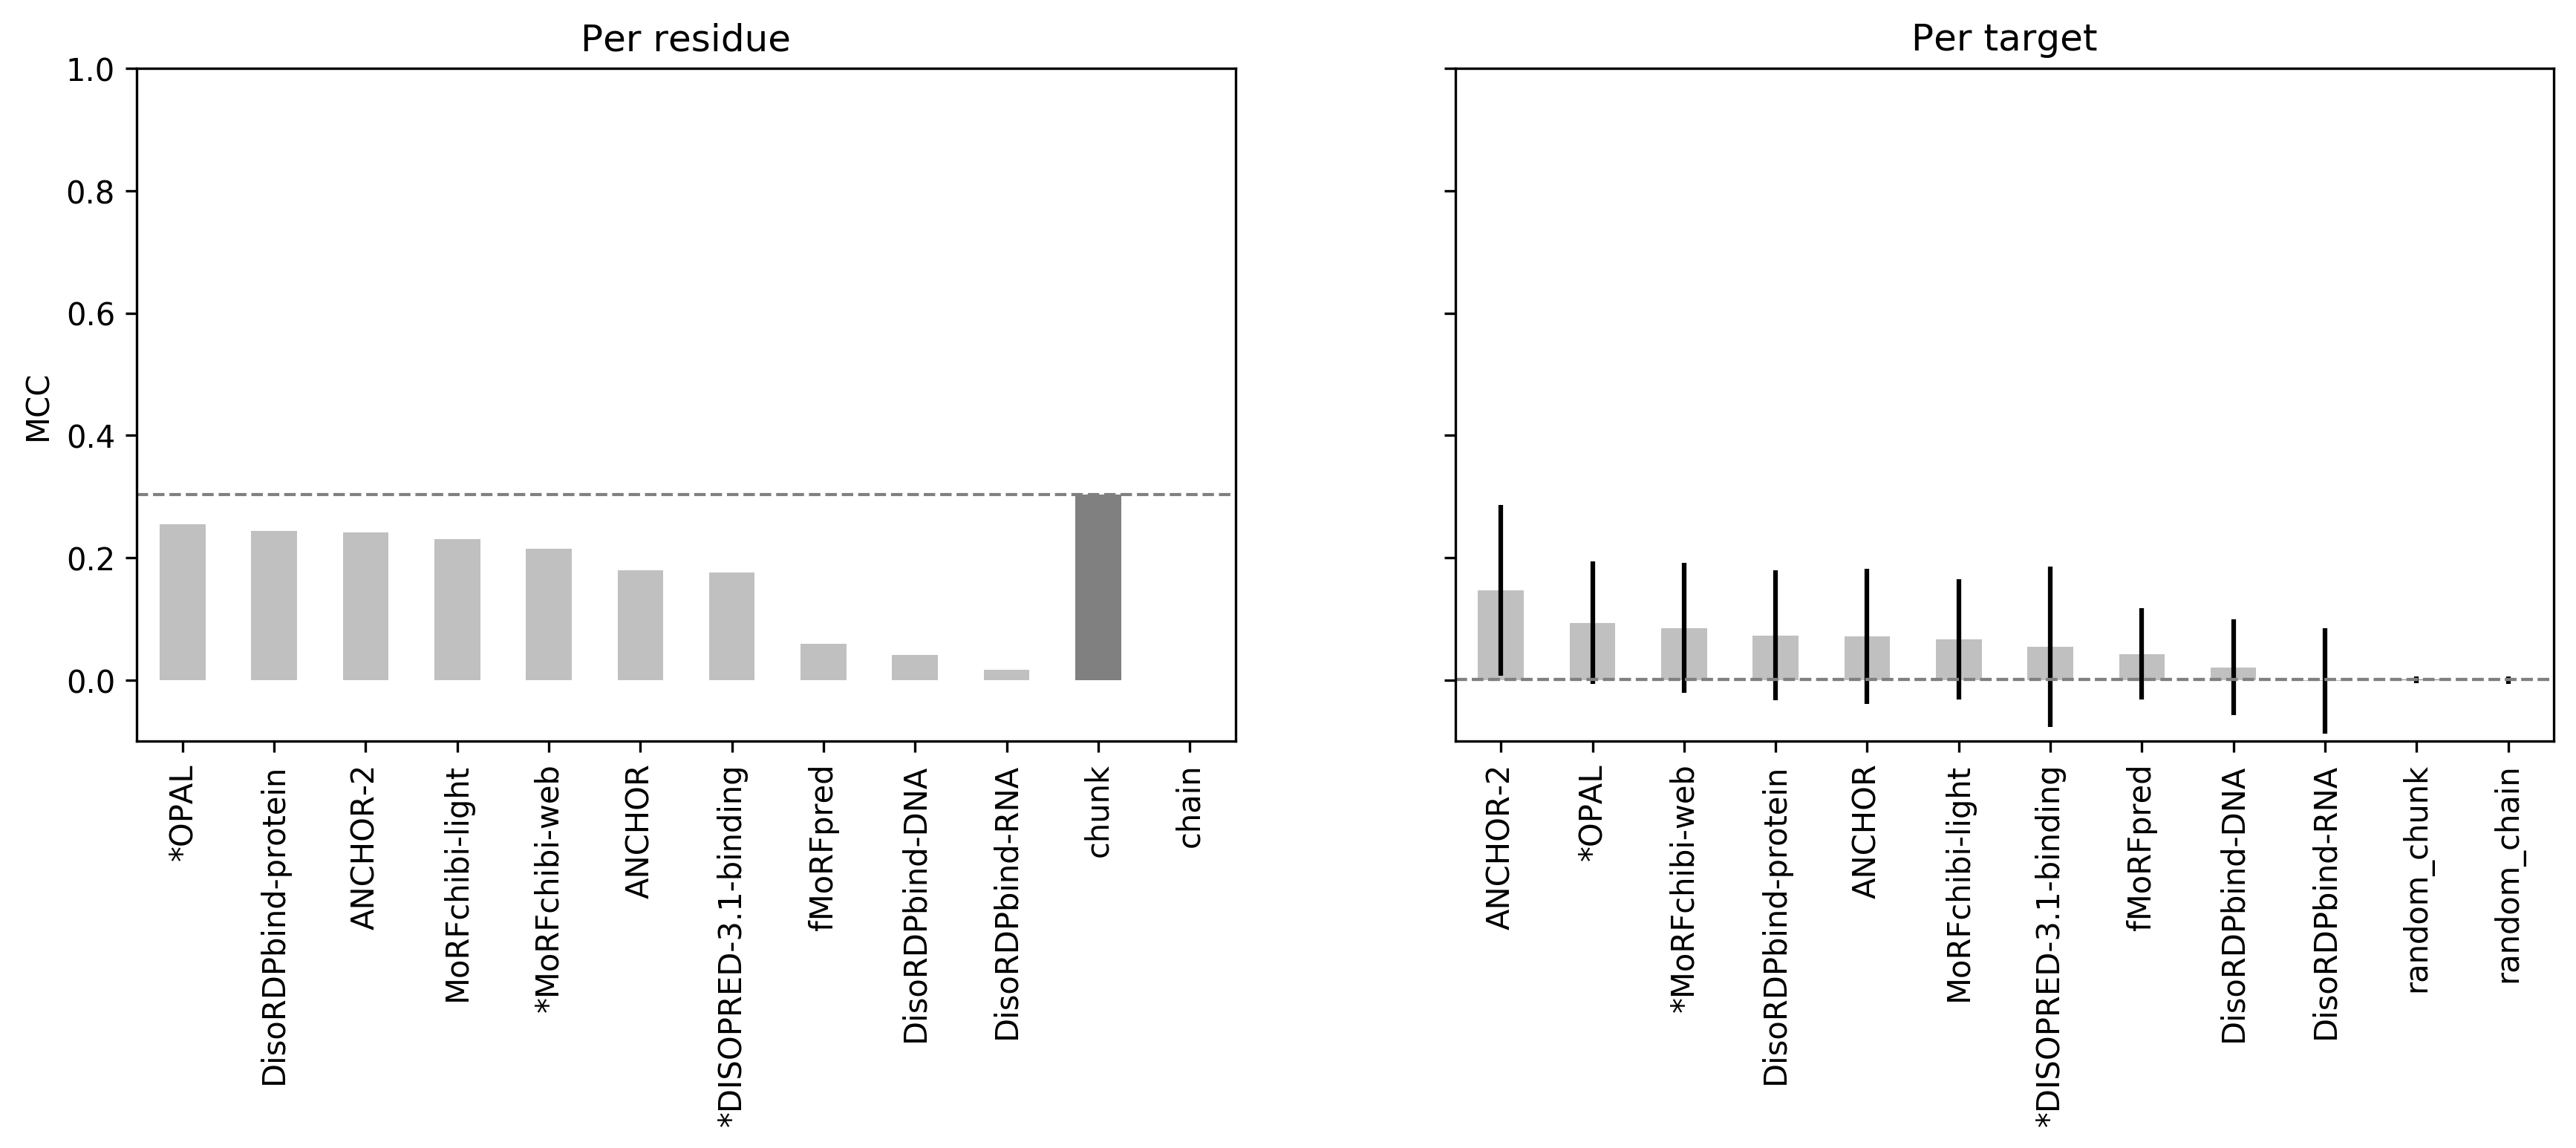

In [42]:
bt_mcc_mean, bt_mcc_std = bt.xs('mcc', level=1).mean(axis=1), bt.xs(
    'mcc', level=1).std(axis=1)
pt_mcc_mean, pt_mcc_std = pt.xs('mcc', level=1).mean(axis=1), pt.xs(
    'mcc', level=1).std(axis=1)
pt_mcc_mean.drop('B007_DisoRDPbind', inplace=True)
# init figure
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
# set different colors for prediction and baselines
colors = ['silver'] * len(p) + ['grey'] * len(b)
# draw per-residue bars
p['MCC'].sort_values(ascending=False).rename(index=labels_names).append(
    b['MCC'].sort_values(ascending=False)).plot.bar(color=colors, ax=axes[0])
axes[0].set_ylabel('MCC')
axes[0].set_ylim(-.1, 1)
axes[0].set_title('Per residue')
# draw horizontal line at maximum baseline
axes[0].axhline(b['MCC'].max(), linestyle='--', color='grey', linewidth=1)
# draw mean per-target bars
mcc_mean = pt_mcc_mean.sort_values(ascending=False).rename(index=labels_names).append(
    bt_mcc_mean.sort_values(ascending=False))
# order std with the same order as mean
mcc_std = pt_mcc_std.rename(index=labels_names).append(bt_mcc_std).loc[mcc_mean.index]
# plot bars with error
mcc_mean.plot.bar(color=colors, ax=axes[1], yerr=mcc_std / 2)
# draw horizontal line at maximum baseline
axes[1].axhline(bt_mcc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].axhline(bt_mcc_mean.max(), linestyle='--', color='grey', linewidth=1)
axes[1].set_title('Per target');

Overall (left panel) and average per-target (right panel) MCC. Light gray bars represent published prediction methods; dark gray bars represent baseline prediction methods. On the right panel standard deviation is shown as an error bar.

### Per target accuracy
Balanced accuracy score for each target for each prediction methods (including baslines)

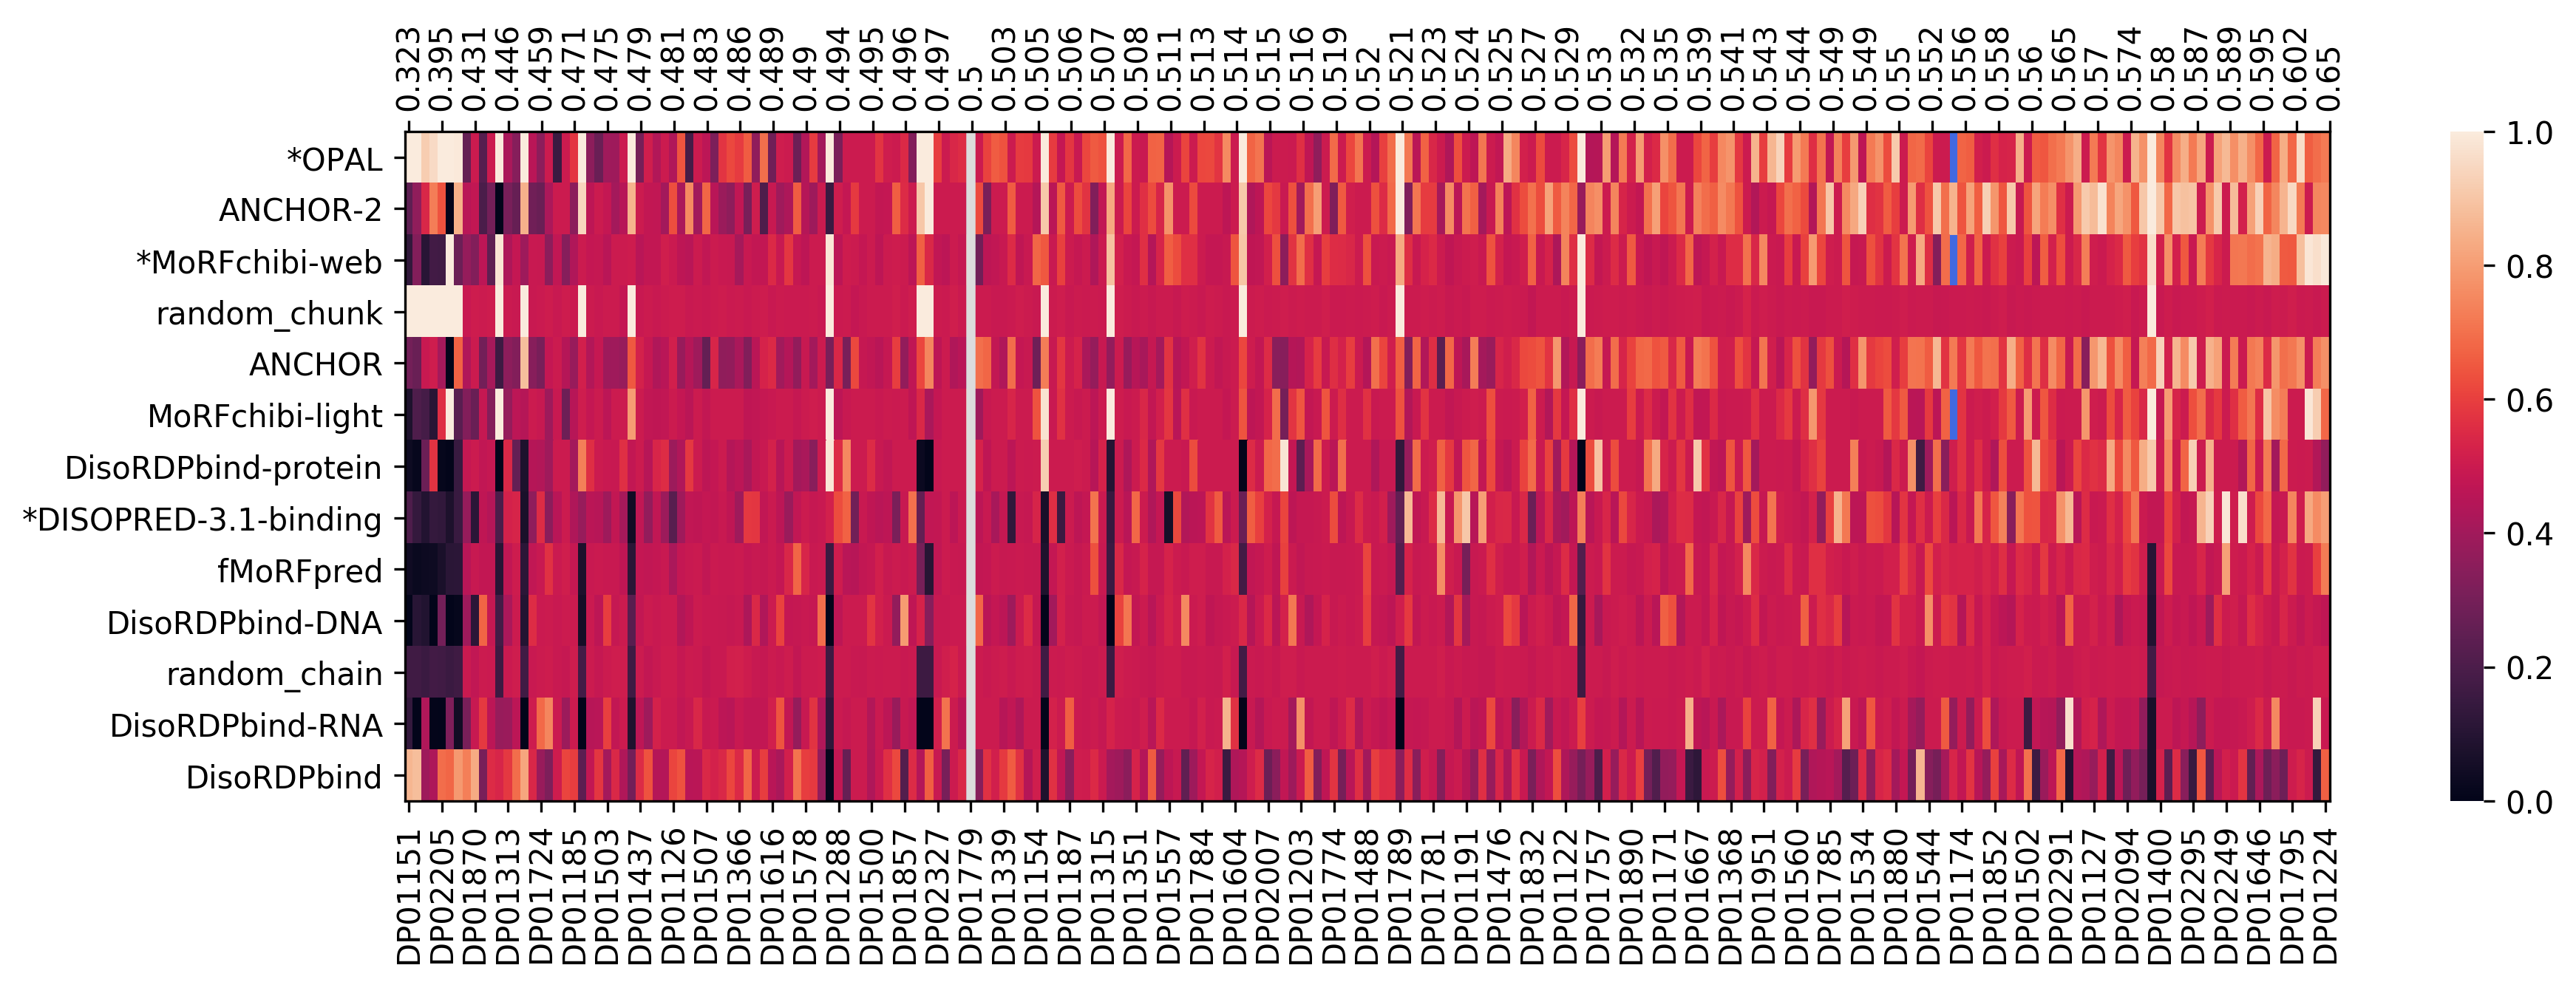

In [179]:
metric = 'bal_acc'
threshold = 0.5

# sort columns by column average
target_heatmap = target_scores.xs(metric, level=1).reindex(target_scores.xs(
    metric, level=1).mean().sort_values().index, axis=1)
# sort rows by row average
target_heatmap = target_heatmap.loc[target_scores.xs(
    metric, level=1).mean(axis=1).sort_values(ascending=False).index]

fig, ax = plt.subplots(figsize=(14, 4))
ax = sns.heatmap(target_heatmap.rename(index=labels_names), ax=ax)
ax.axes.get_yaxis().get_label().set_visible(False)
ax.set_facecolor('royalblue')


def find_nearest(array, value):
    array = np.fromiter(array, dtype=float)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


ax2 = ax.twiny()
ax2tick_location = ax.xaxis.get_ticklocs(
)  #Get the tick locations in data coordinates as a numpy array

ax2tick_lbls = [
    target_heatmap.mean().values[list(target_heatmap.columns).index(
        l.get_text())] for l in ax.xaxis.get_ticklabels()
]

ax2.set_xticks(ax2tick_location)
ax2.set_xticklabels(np.array(ax2tick_lbls).round(3))
thr_x = dict(zip(map(float, ax2tick_lbls), ax2tick_location)).get(
    find_nearest(map(float, ax2tick_lbls), threshold))
ax.axvline(thr_x, linewidth=3, color='gainsboro')
ax2.tick_params(axis='x', rotation=90)

#DP01196 29466327 23-215 CEM --> 29466327 183-203 CEM

Heatmap of the predictors accuracy for each target. The higher the accuracy the lighter the color. Non-predicted targets are shown in blue. $x$ and $y$ axes are sorted by average accuracy over rows and columns respectively. A white semi-transparent vertical line marks the point where the average accuracy scores for a target is below (left) or above (right) $0.5$. Accuracy score approaches $0.5$ for a random classifier. Accuracy $< 0.5$ indicates anti-correlation between predicted and reference classes. Targets with an average accuracy score $<0.5$ are:

In [180]:
low_acc_targets = target_heatmap.mean()[
    target_heatmap.mean() <= 0.5].to_frame()
for i, t in enumerate(low_acc_targets.index, 1):
    sep = '\t'
    if i % 6 == 0:
        sep = '\n'
    print(t + sep, end='')

DP01151	DP01471	DP01942	DP01521	DP02205	DP01512
DP01776	DP01456	DP01870	DP01130	DP01498	DP01146
DP01313	DP01474	DP02066	DP01501	DP01724	DP01794
DP01199	DP01181	DP01185	DP01293	DP01170	DP01990
DP01503	DP02120	DP01296	DP01876	DP01437	DP01619
DP01999	DP01128	DP01126	DP01323	DP01319	DP01499
DP01507	DP01436	DP01528	DP01887	DP01366	DP01556
DP01426	DP01462	DP01616	DP01141	DP02301	DP01893
DP01578	DP01139	DP01941	DP01148	DP01288	DP01440
DP02117	DP02326	DP01500	DP01475	DP01622	DP01281
DP01857	DP01972	DP01787	DP02078	DP02327	DP01527
DP01967	DP01334	DP01779	DP01834	

###  Target correlation matrix

Commonly, experimental data has a bias for low disorder-content. DisProt targets have high disorder-content. Classifiers have been trained/engineered on low disorder-content. I expect difficult targets to have high disorder content. To verify is there is any correlation between target features I'm plotting 4 selected features against each other (Balanced accuracy, F1-Score, Sequence length and ID content). A fifth feature (ID position) divides the datasets in subsets. ID position is calculated as the average of the indexes of disordered residues along the sequence. A correlation is observed in a subset if its points gather around a diagonal.

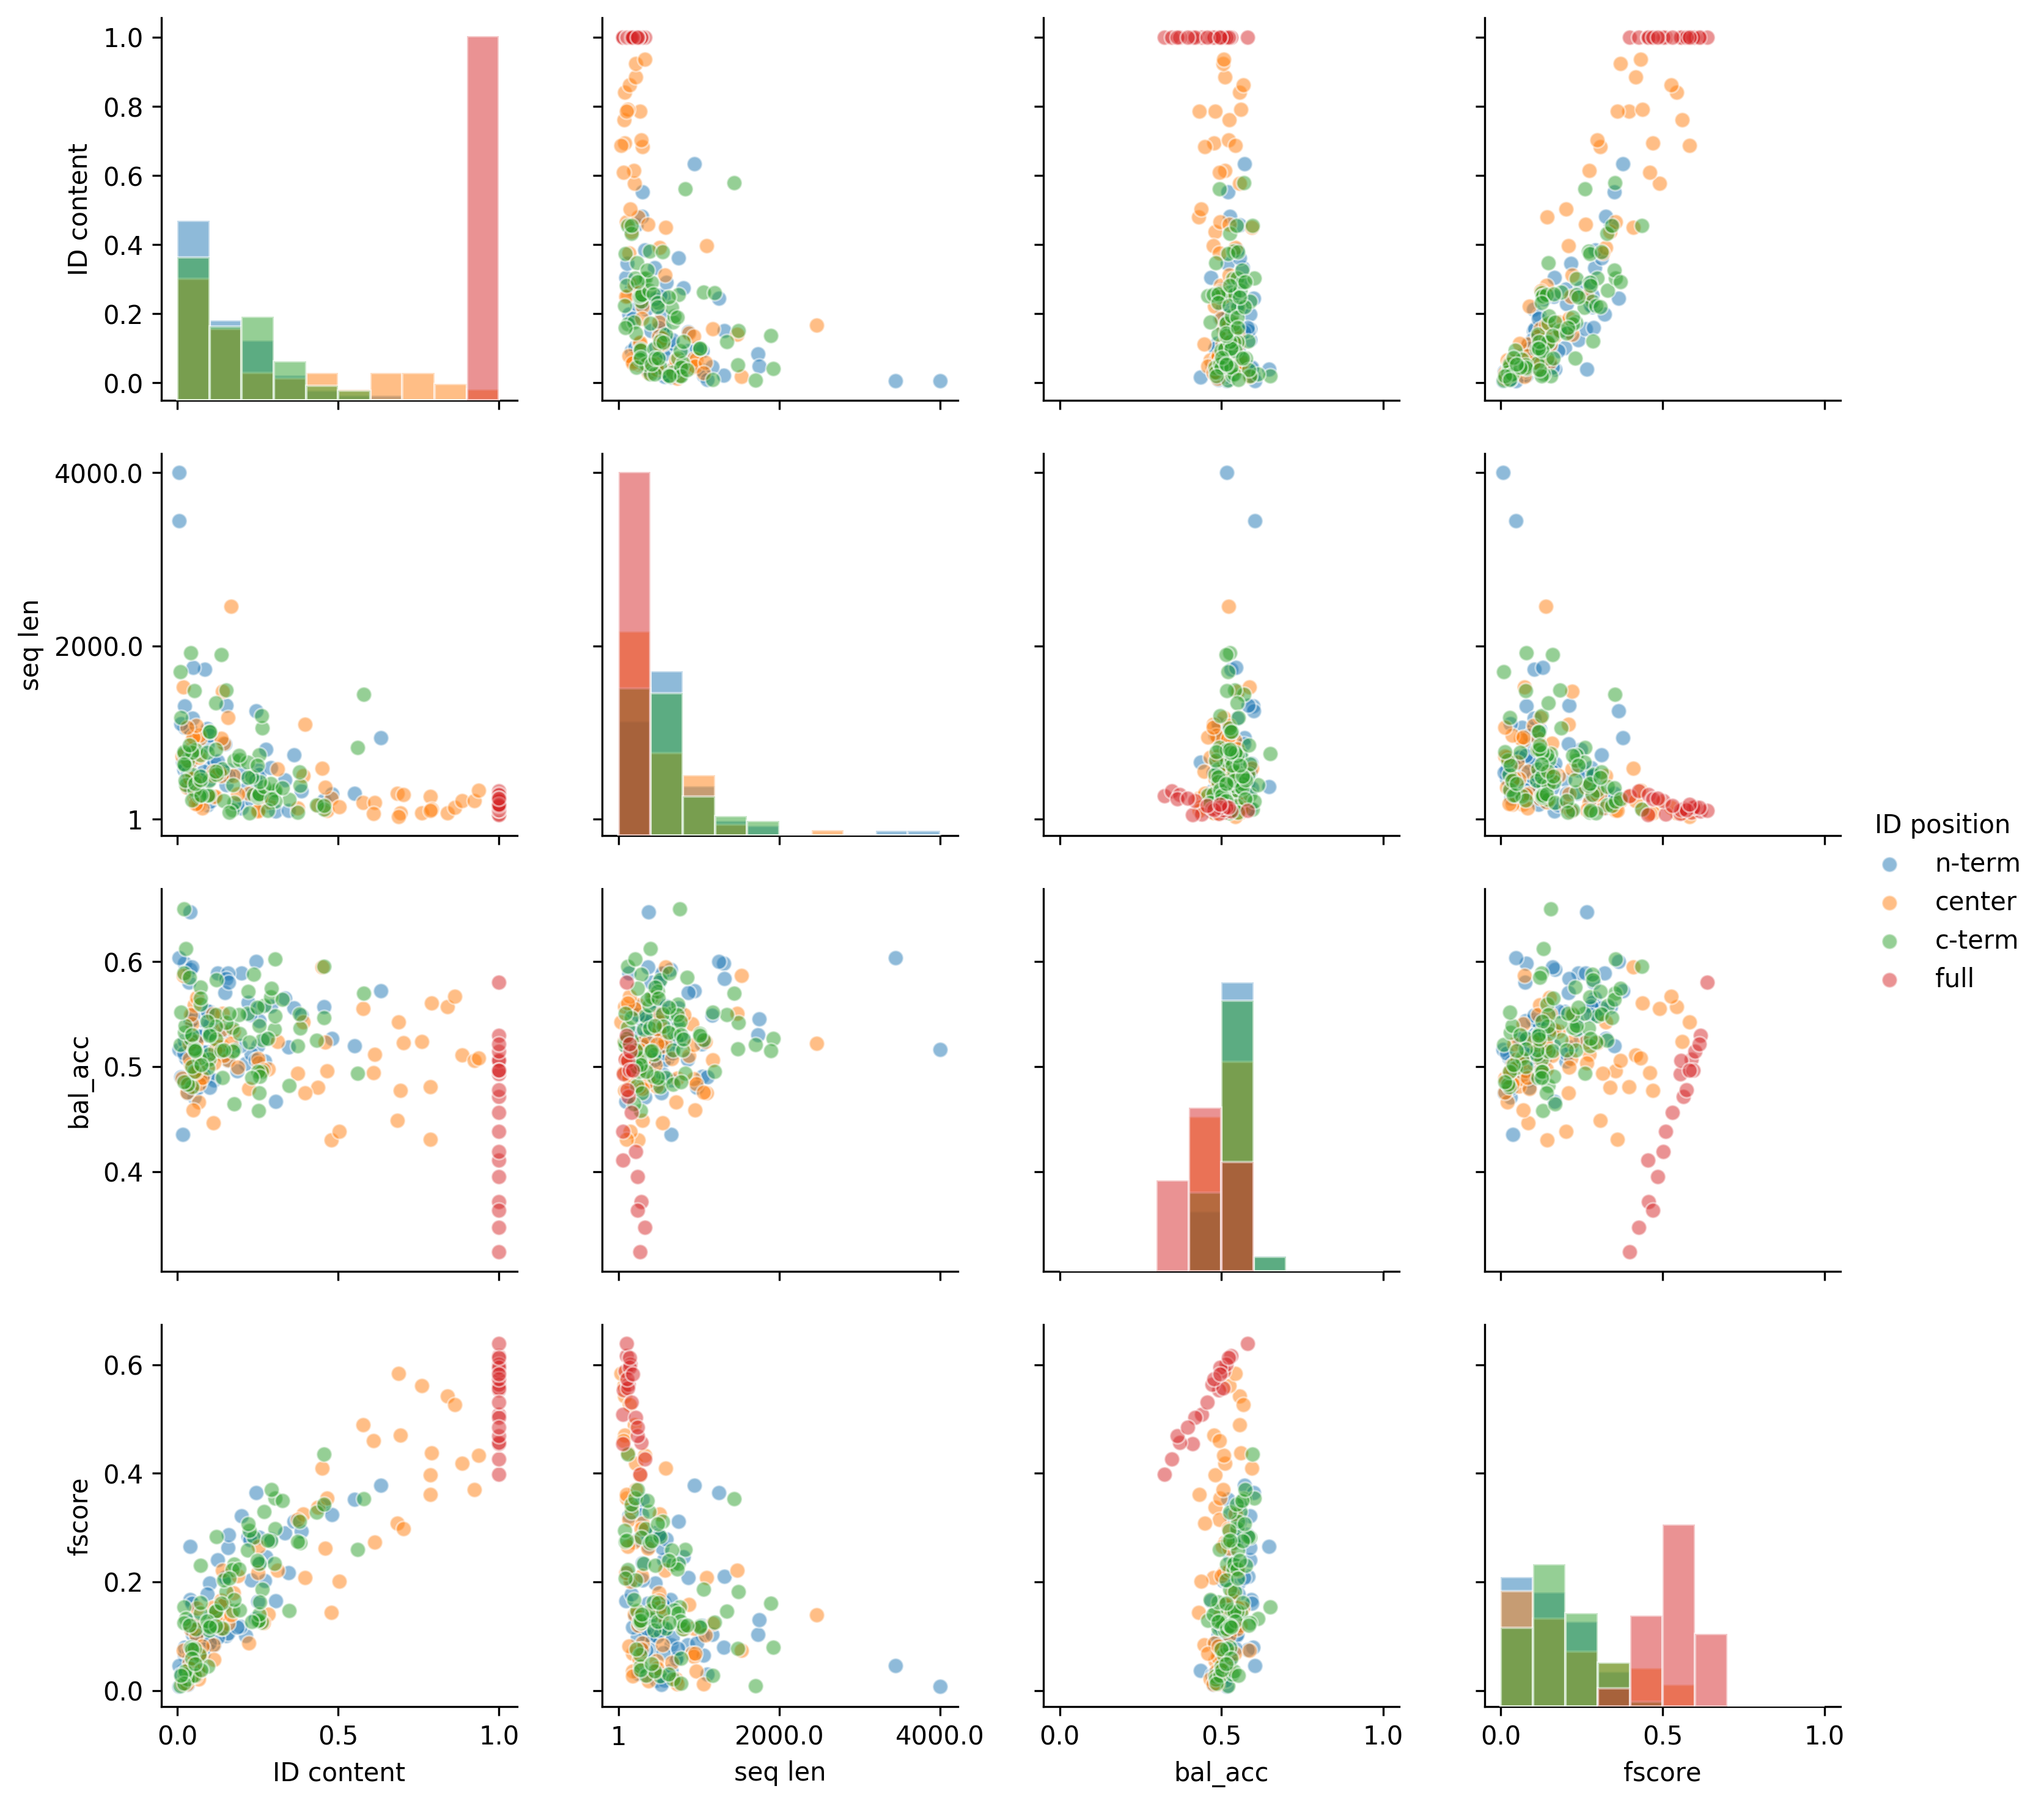

In [181]:
def avg_id_pos(s):
    s = s[~np.isnan(s)]
    p = np.argwhere(s == np.amax(s)).flatten() / s.size
    if np.unique(s).size == 1:
        pos = 'full' if np.mean(s) == 1 else 'none'
    else:
        p = np.mean(p)
        if p < 0.33:
            pos = 'n-term'
        elif 0.33 <= p <= 0.66:
            pos = 'center'
        else:
            pos = 'c-term'
    return pos


# get per-target scores averaged over methods
target_avg_scores = target_scores.mean(level=1).transpose()
# calculate disorder content from loaded reference
id_content = pd.DataFrame([[p, np.nanmean(refdict[p]['states'])]
                           for p in refdict
                           ]).set_index([0]).rename(columns={1: 'ID content'})
# calculate protein length from loaded reference
p_len = pd.DataFrame([[p, len(refdict[p]['seq'])] for p in refdict
                      ]).set_index([0]).rename(columns={1: 'seq len'})
# rescale length in range (0, 1) --> I can set range=(0, 1) when drawing
maxlen = p_len.max().max()
p_len = p_len / maxlen
# calculate average position of disorder in disprot entry
pos = pd.DataFrame([(p, avg_id_pos(refdict[p]['states'])) for p in refdict
                    ]).set_index([0]).rename(columns={1: 'ID position'})
# concatenate everything
corr = pd.concat([id_content, target_avg_scores, p_len, pos],
                 axis=1,
                 sort=False)

# draw correlation matrix for selected columns
v = ["ID content", "seq len", "bal_acc", "fscore"]
g = sns.pairplot(
    corr,
    vars=v,
    hue="ID position",
    diag_kind="hist",
    plot_kws={'alpha': 0.5},  # set transparency of dots
    diag_kws={
        'alpha': 0.5,  # set transparency of hist bars
        'edgecolor': 'w',  # set edge color of hist bars
        'bins': 10,
        'range': (0, 1),  # make all bins boundaries equal
        'density': True,
    })  # rescale y axis in range (0, 1)

# redraw x-ticks of seq len for its actual scale
vi = v.index("seq len")
maxlen = round(maxlen /
               (10**int(math.log10(maxlen)))) * (10**int(math.log10(maxlen)))
g.axes[vi, vi].set_xticks([0, 0.5, 1], minor=False)
g.axes[vi, vi].set_xticklabels([1, maxlen / 2, maxlen])
g.axes[vi, vi].set_yticks([0, 0.5, 1], minor=False)
g.axes[vi, vi].set_yticklabels([1, maxlen / 2, maxlen]);

Correlation matrix of Balanced accuracy, F1-Score, Sequence length and ID content. Average position of disorder is color-coded. Figure matrix is symmetrical. Plots along diagonal axis display single variables distributions. No meaningful correlation is observed.

### ROC curve
Receiver Operator Characteristic plot for predictors and baselines

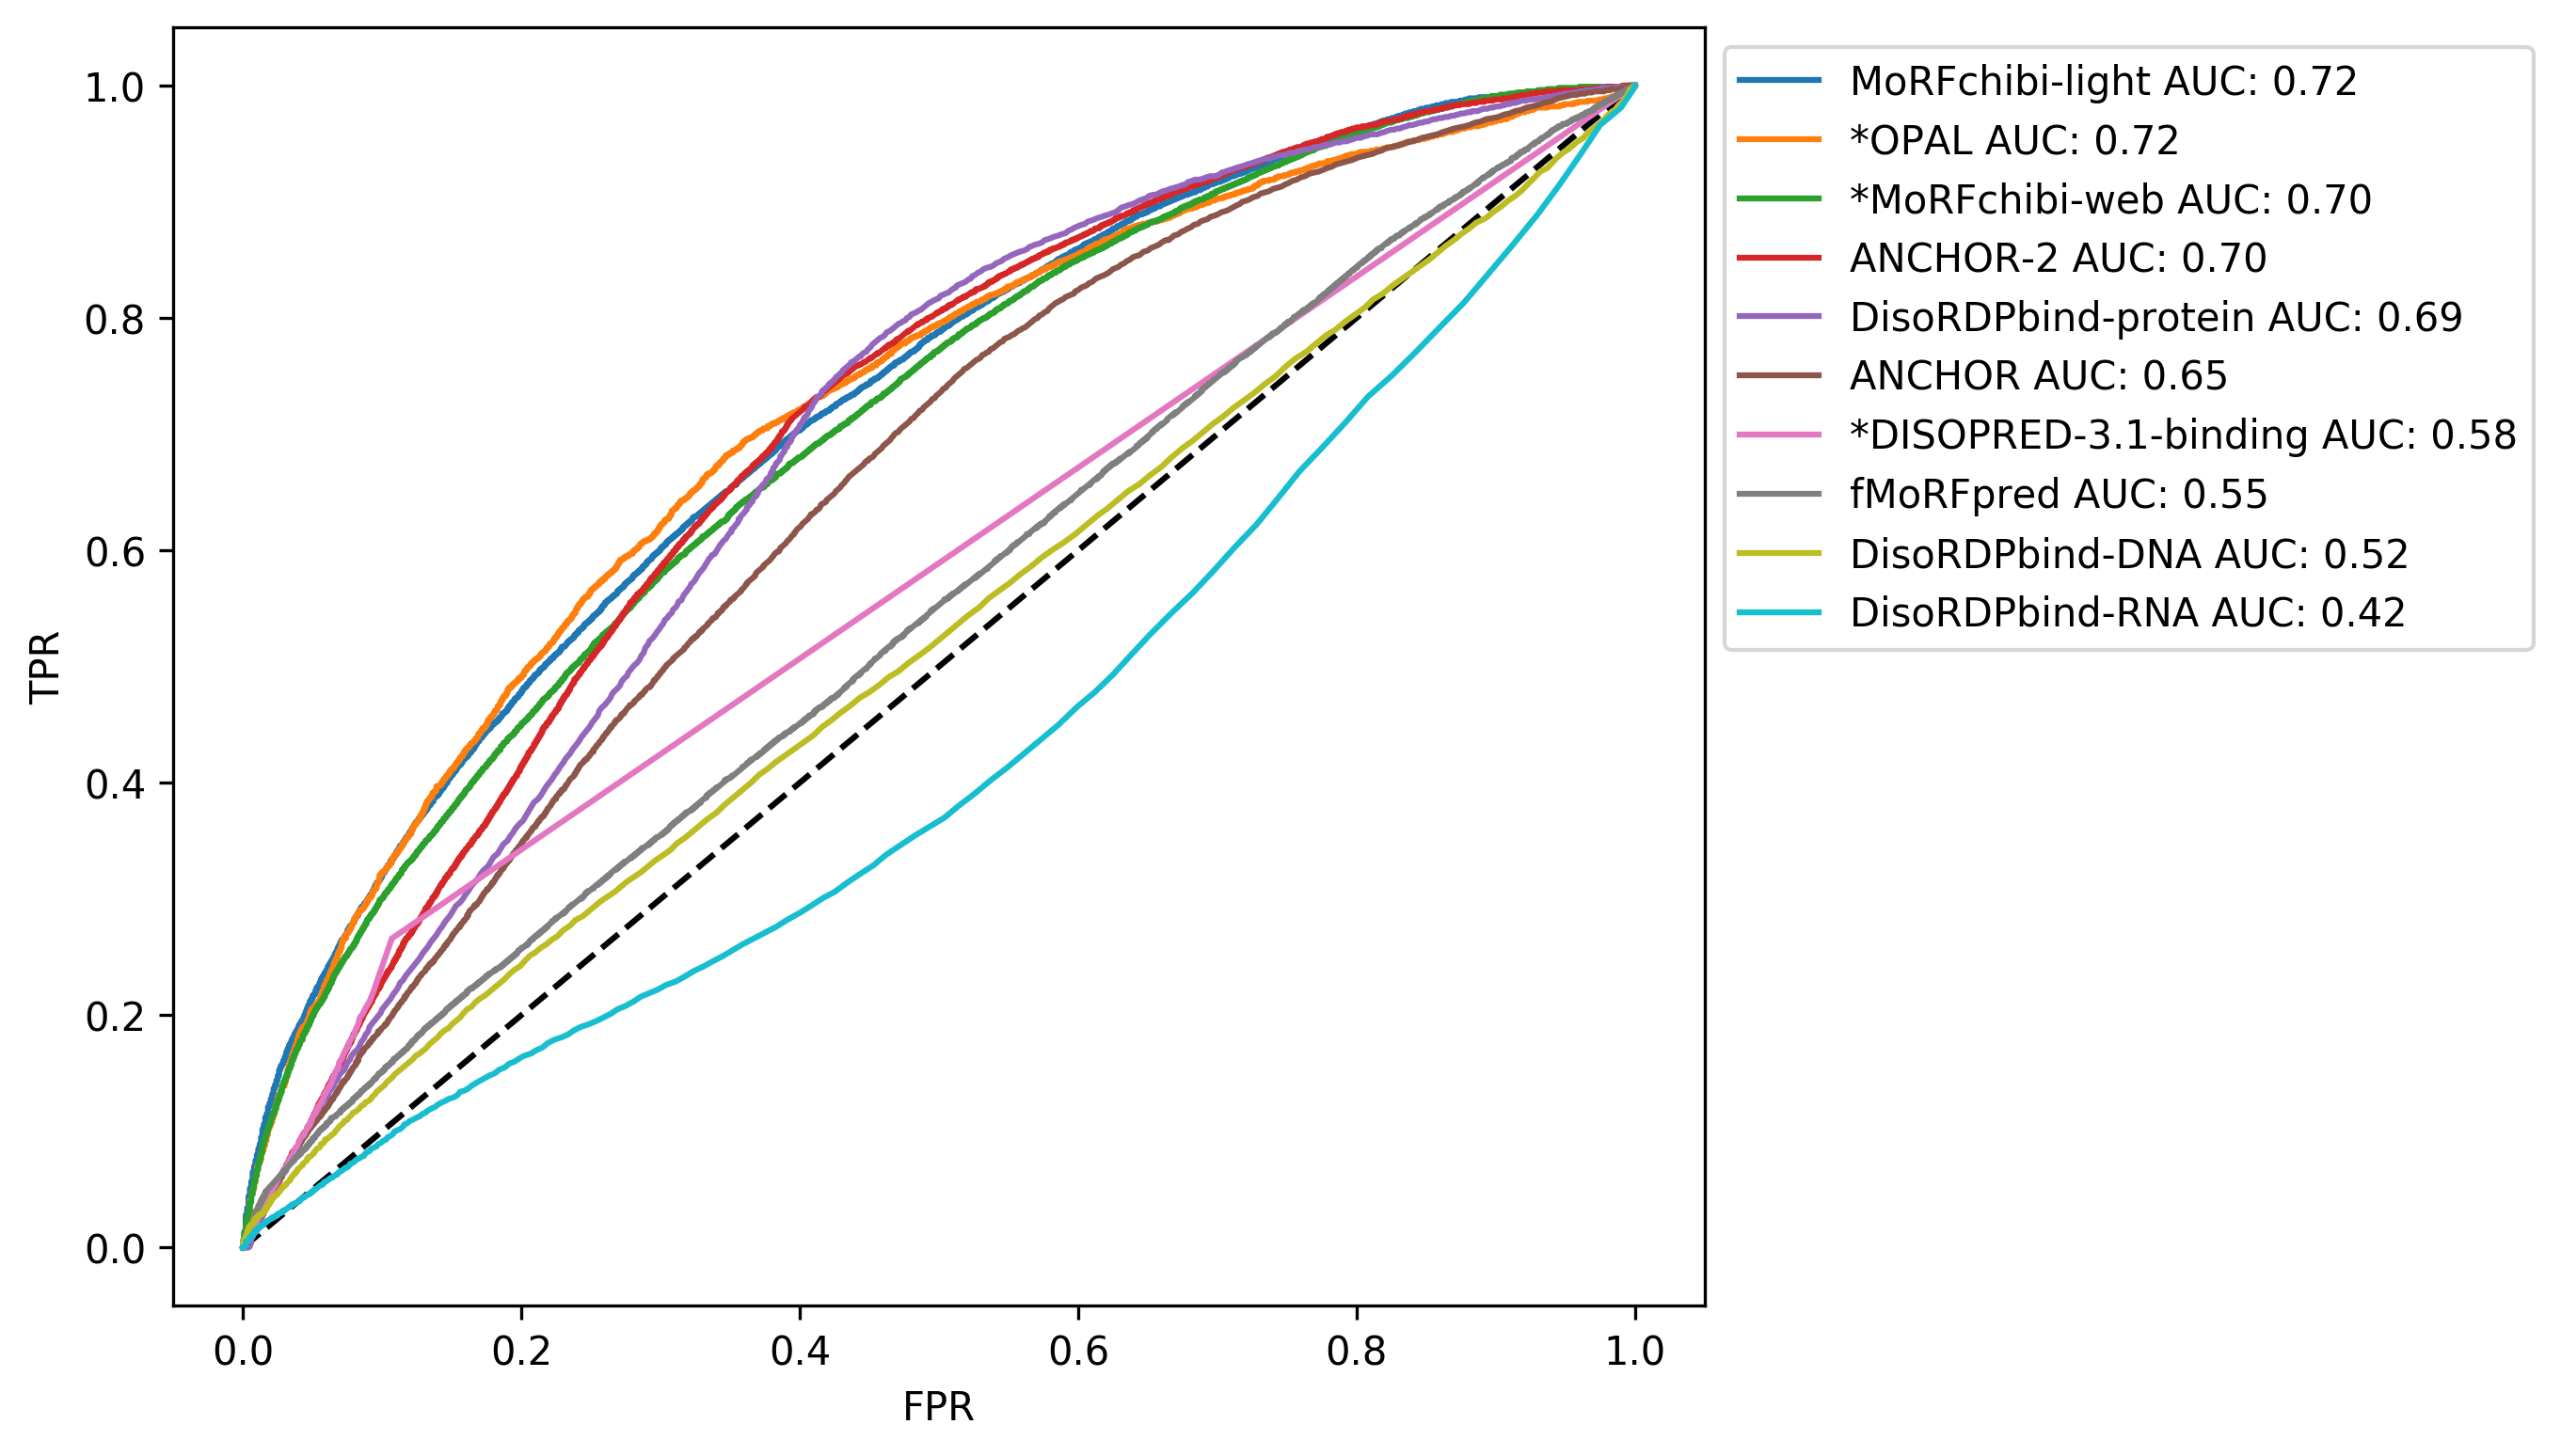

In [182]:
# # initialize a figure and an ax
fig, ax = plt.subplots(figsize=(7, 6))
# # plot diagonal
ax.plot([0, 1], [0, 1], linestyle='--', color='k')

# plot all curves in evaluation file
for curve_data in sorted(rocs, key=lambda d: d[1],
                         reverse=True)[:10] + rocs_base:
    code, auc_roc, x, y, thr = curve_data
    ax.plot(x, y, label='{} AUC: {:.2f}'.format(labels_names.get(code), auc_roc))

ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_xlabel('FPR')
ax.set_ylabel('TPR');

False Positive Rate (FPR) on $x$ axis, True Positive Rate (TPR) on $y$ axis. Methods are sorted by their Area Under the Curve (AUC). Only first ten methods plus baselines are shown.

### PR curve
Precision Recall curve plot for predictors and baselines

/home/marnec/.local/share/virtualenvs/caid-ICjYQIts/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


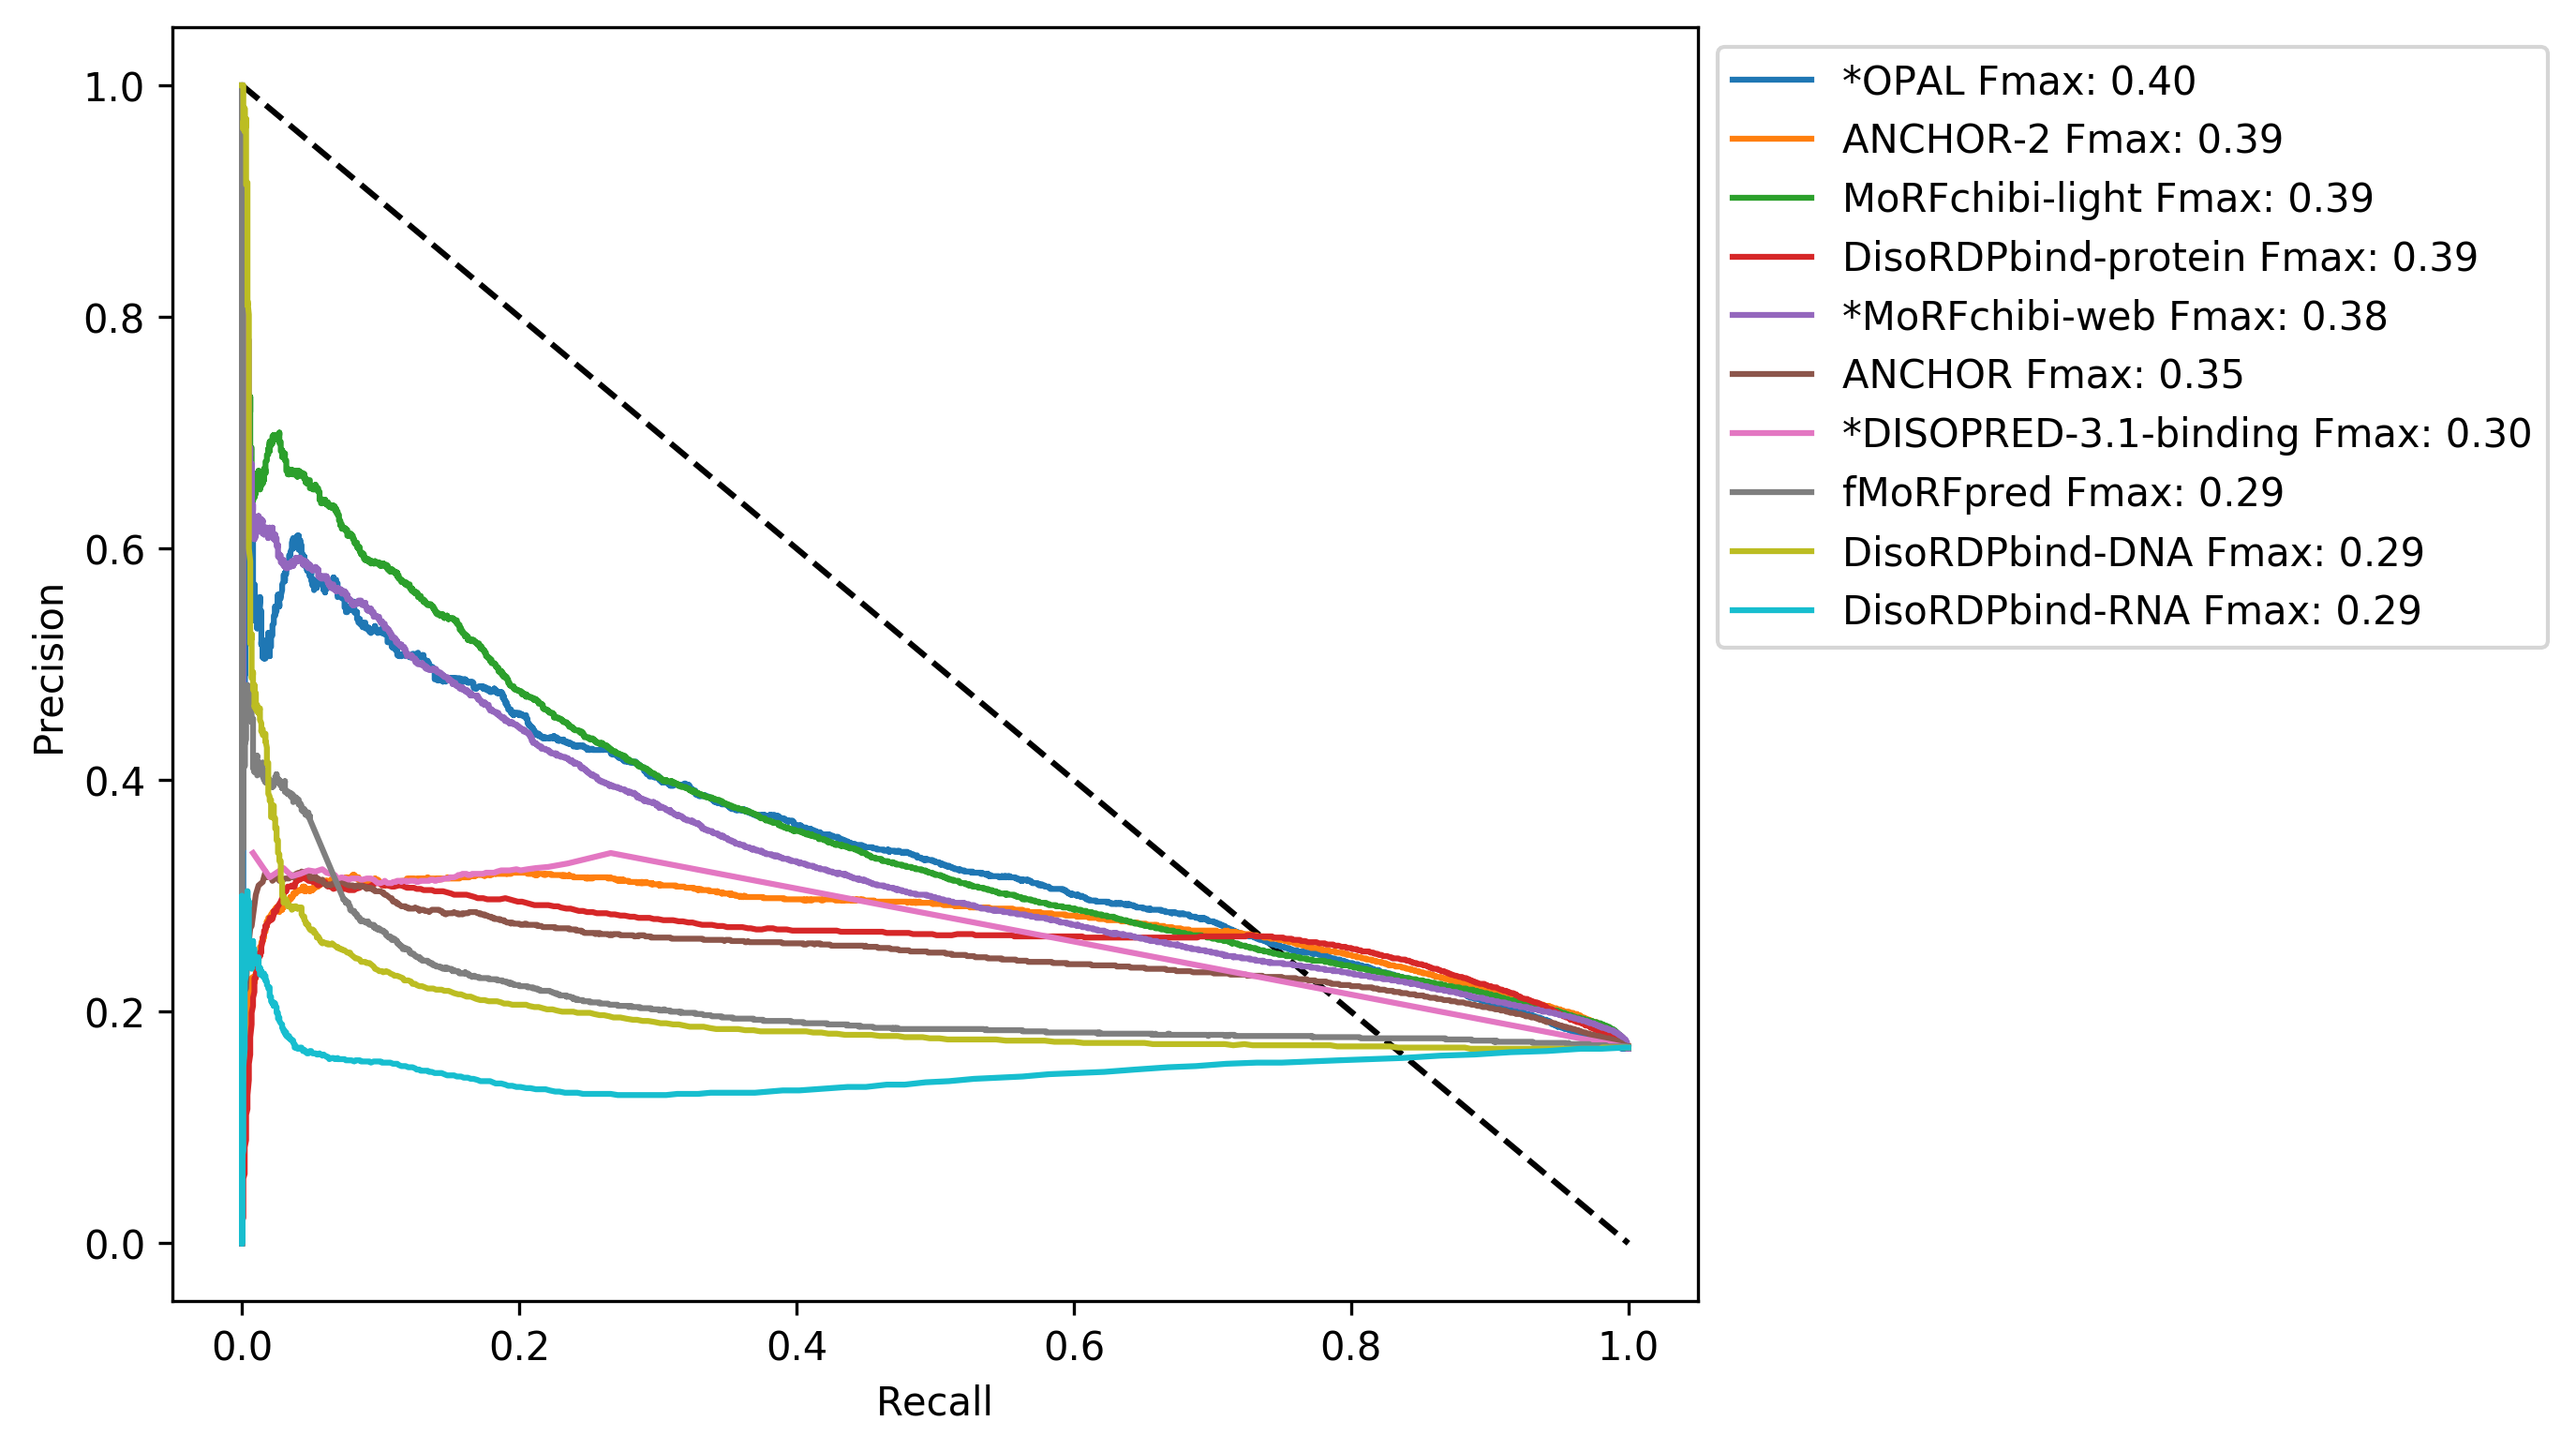

In [40]:
# # initialize a figure and an ax
fig, ax = plt.subplots(figsize=(7, 6))
# # plot diagonal
ax.plot([0, 1], [1, 0], linestyle='--', color='k')
fmaxf = lambda d: np.nanmax(2 *d[2]*d[3] / (d[2]+d[3]))

# plot all curves in evaluation file
for curve_data in sorted(prcs, key=fmaxf, reverse=True)[:10] + prcs_base:
    code, auc_score, x, y, thr = curve_data
    fmax = fmaxf(curve_data)
    ax.plot(x, y, label='{} Fmax: {:.2f}'.format(labels_names.get(code, code), fmax))

ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');

Recall/Sensitivity on $x$ axis, Precision/Selectivity on $y$ axis. Methods are sorted by their Area Under the Curve (AUC). Only first ten methods plus baselines are shown.

In [184]:
def filter_rescale(data, rrange):
    rescaled = []
    for code, aucs, x, y, thr in data:
        filt = np.where((rrange[0] <= x) & (x <= rrange[1]))
        auc_score = metrics.auc(x[filt], y[filt]) / (rrange[1] - rrange[0])
        rescaled.append([code, auc_score])
    return rescaled

### pROC/pPR scatter plot
Plot of the AUCs from the ROC curve and PR curve

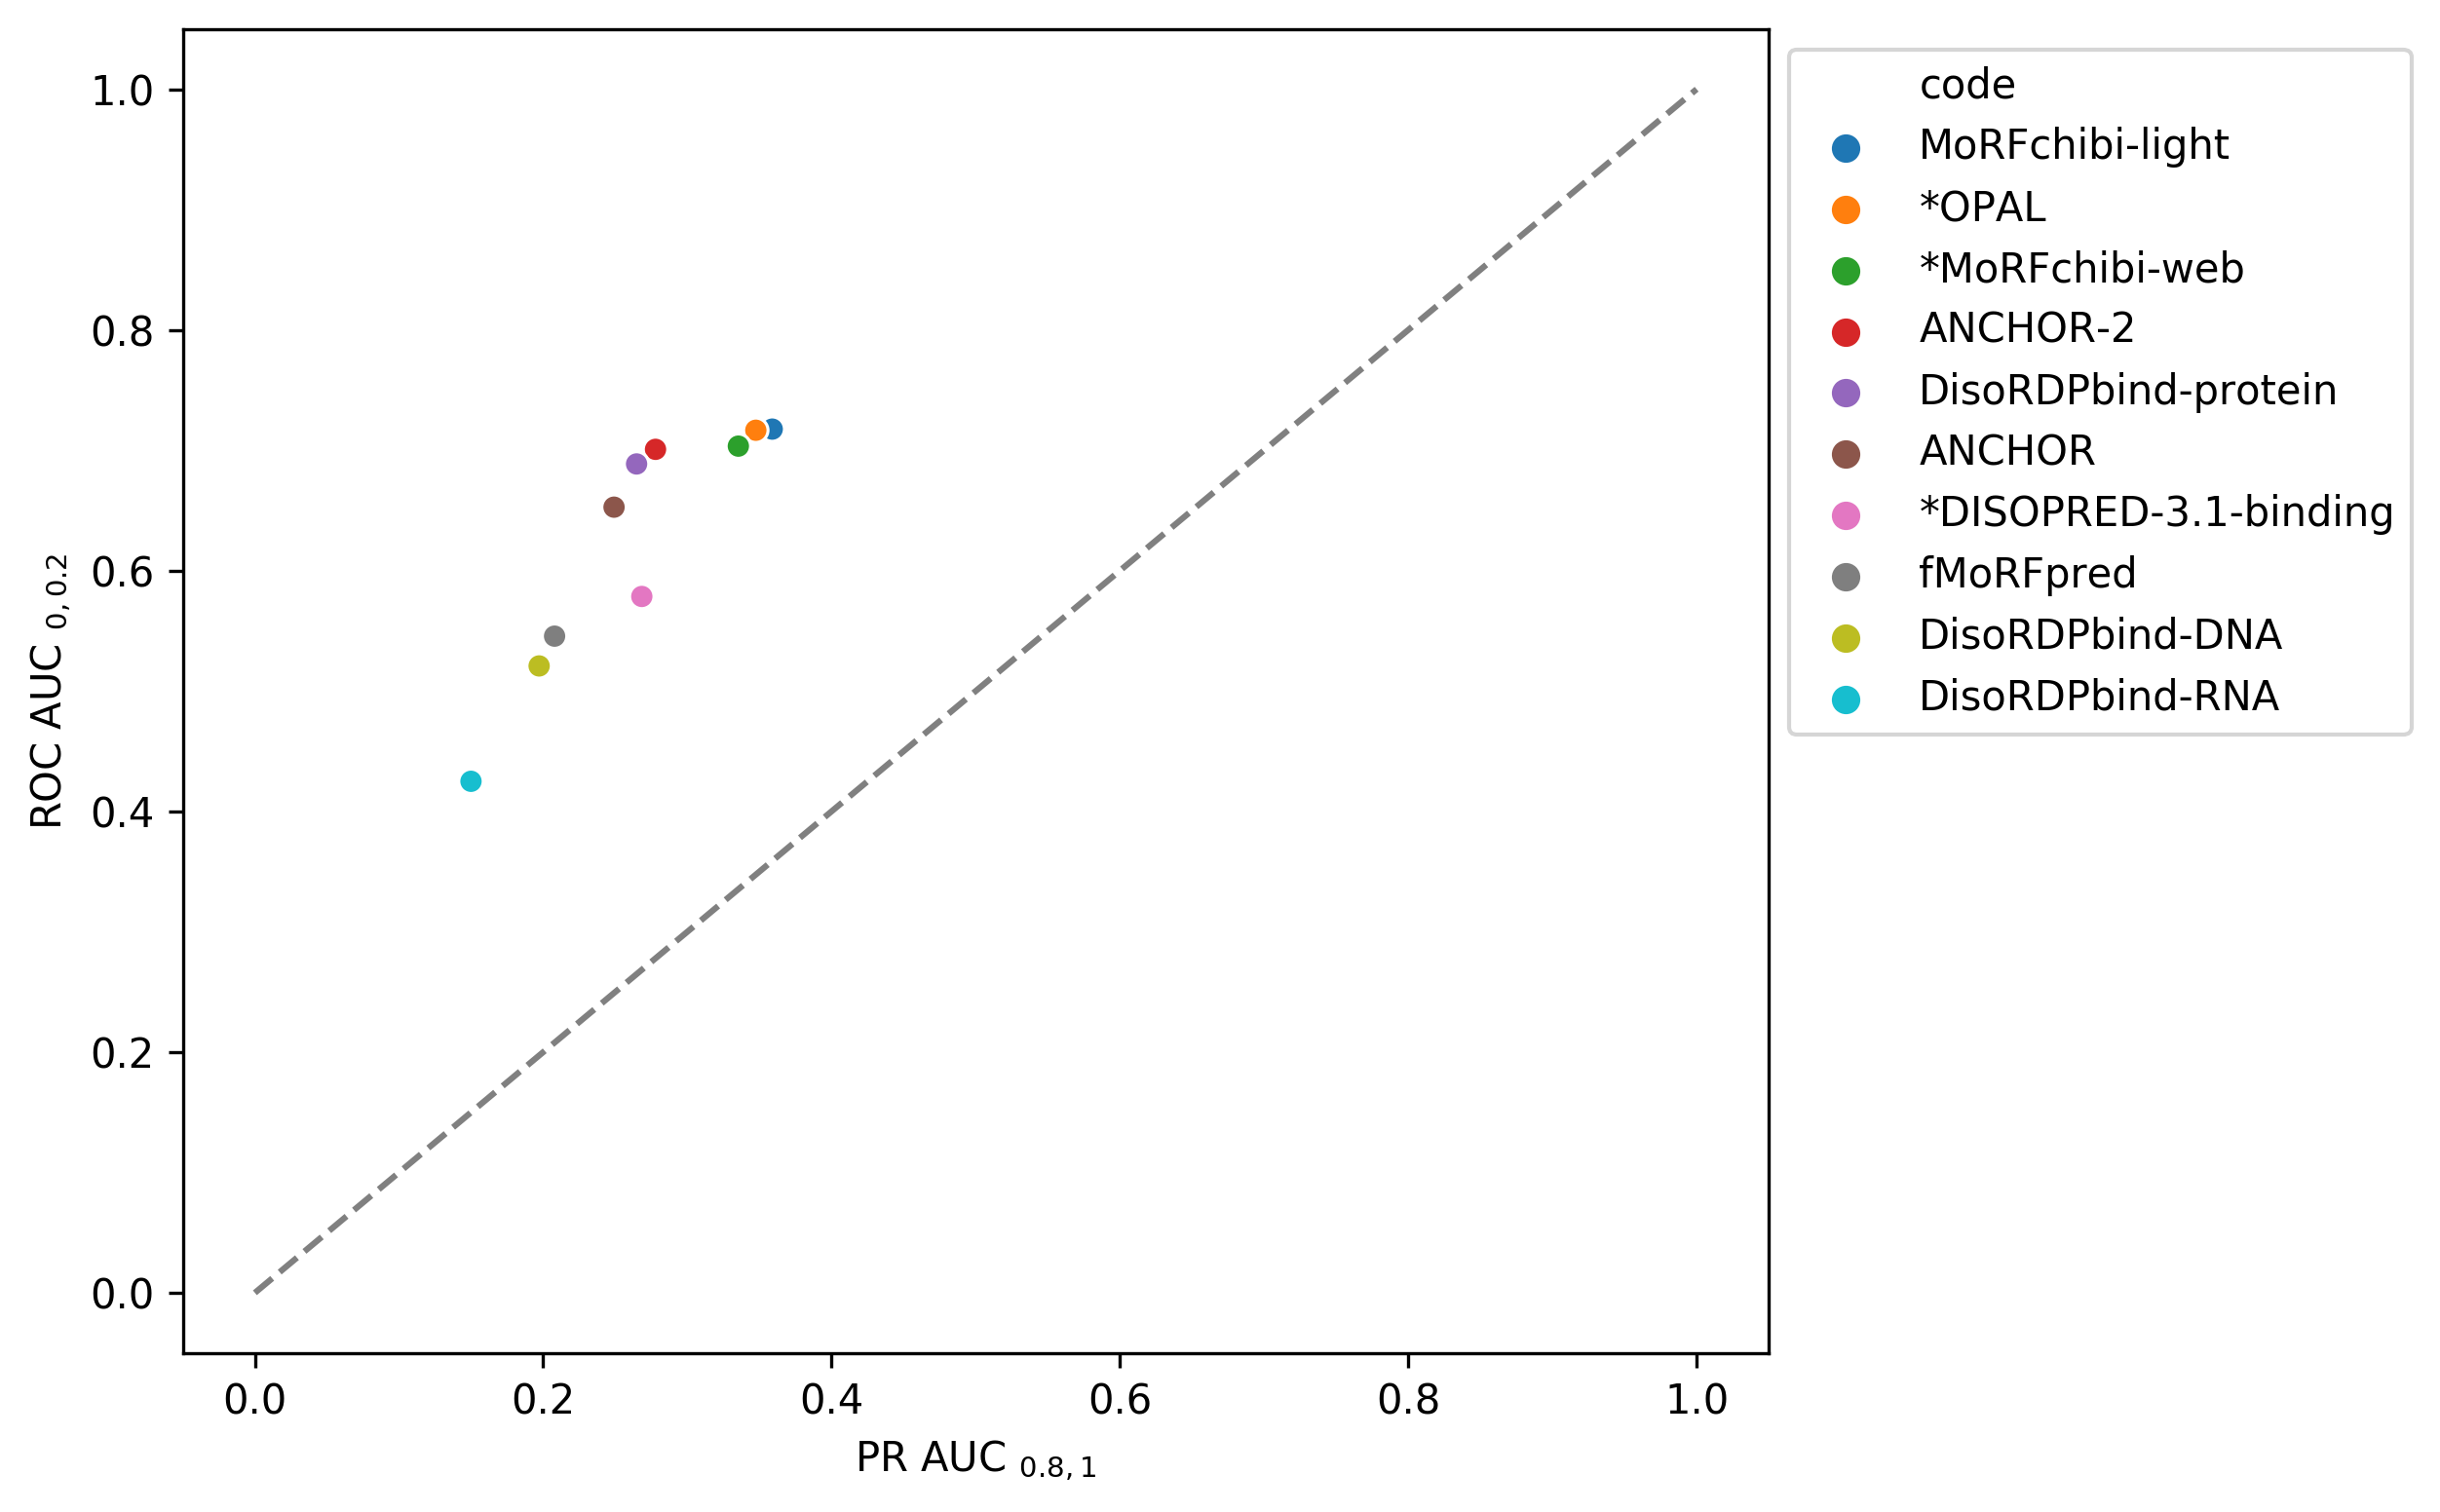

In [185]:
x = pd.DataFrame(filter_rescale(rocs, (0, 1)),
                 columns=['code', 'AUC ROC']).set_index('code')
y = pd.DataFrame(filter_rescale(prcs, (0, 1)),
                 columns=['code', 'AUC PR']).set_index('code')
data = pd.concat([x, y], axis=1).reset_index()

fig, ax = plt.subplots(figsize=(7, 6))
data = data.sort_values(by='AUC ROC', ascending=False).set_index("code").rename(index=labels_names)

ax = sns.scatterplot(data=data,
                     x='AUC PR',
                     y='AUC ROC',
                     hue=data.index,
                     ax=ax)

ax.legend(bbox_to_anchor=(1, 1), loc=2)
ax.set_xlabel("PR AUC $_{0.8, 1}$")
ax.set_ylabel("ROC AUC $_{0, 0.2}$")
ax.plot((0, 1), (0, 1), linestyle='--', color='grey');

ROC AUC on the $x$ axis, Precision-Recall (PR) AUC on the $y$ axis. ROC AUC is calculated including ROC curve points with $x$ values (FPR) between 0 and 0.2. PR AUC is calculated including PR curve points with $x$ values (Recall) between 0.8 and 1. Both AUCs are then rescaled to the \[0, 1\] range.

### Average overall ranking
Predictor ranking and ranking statistical significance. Predictors are ranked on average rank from metrics scores: Balanced Accuracy, MCC, Precision, Recall, F1-score, F1-scores on negatives, Precision on negatives, Specificty, ROC AUC, PR AUC.

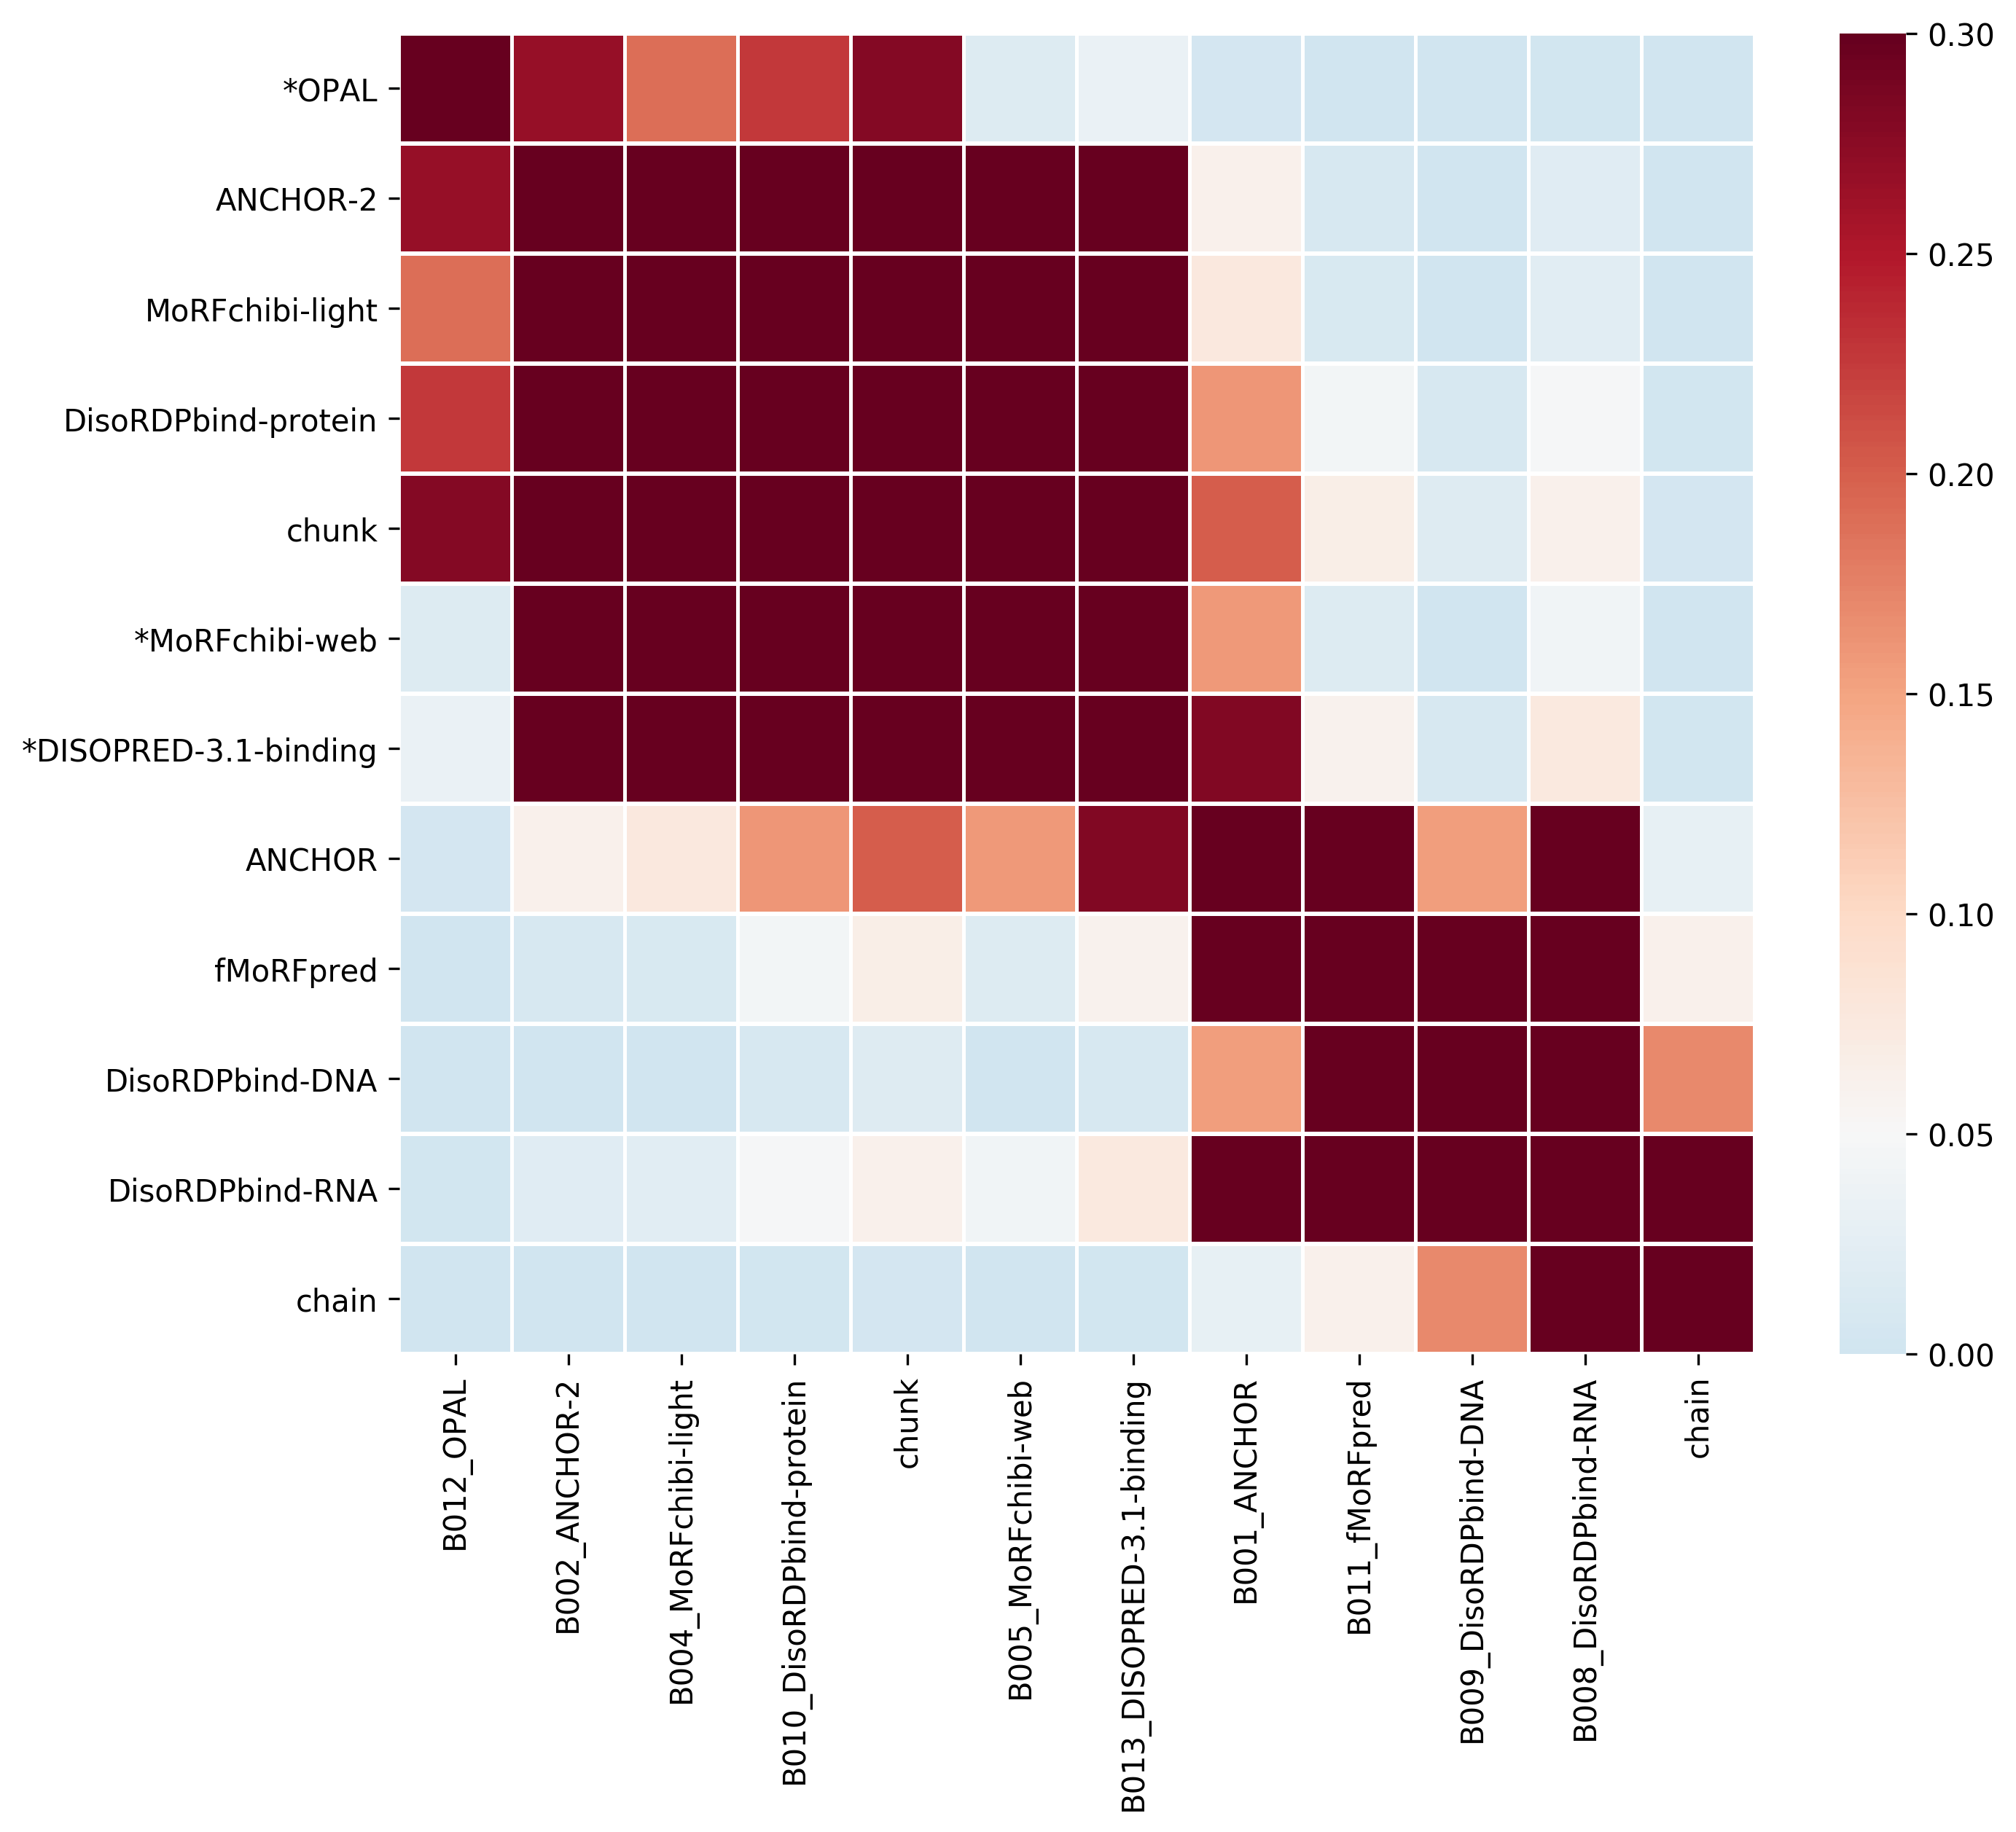

In [186]:
mm = scores[[
    'BAc', 'MCC', 'Pre', 'Rec', 'F1s', 'F1s_n', 'Pre_n', 'Rec_n', 'AUC_ROC',
    'AUC_PRC'
]].rank(axis=0, method='max', ascending=False, na_option='bottom')

coverage = scores['npred'] / scores['nref']

indcol = mm.apply(np.mean, axis=1).sort_values()
dff = pd.DataFrame(index=indcol.index, columns=indcol.index, dtype=float)
del dff.index.name

for indx, rowx in sorted(mm.iterrows(),
                         key=lambda r: r[1].mean(),
                         reverse=True):
    for indy, rowy in sorted(mm.iterrows(),
                             key=lambda r: r[1].mean(),
                             reverse=True):
        dff.loc[indx][indy] = float(ttest_ind(rowx, rowy).pvalue)

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(dff.rename(index=labels_names),
            cmap='RdBu_r',
            annot=False,
            linecolor='w',
            linewidth=1,
            xticklabels=True,
            yticklabels=True,
            ax=ax,
            annot_kws={'size': 9},
            fmt='.2f',
            cbar=True,
            center=0.05,
            vmin=0,
            vmax=0.3)

# ax2 = ax.twiny()
# ax2.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax2.spines['bottom'].set_visible(False)
# ax2.spines['left'].set_visible(False)

# lbls = ax.get_yticklabels()
# ax2.set_xticks(ax.get_xticks())
# ax2.set_xticklabels(coverage[list(map(lambda t: t.get_text(), lbls))].values.round(3))

plt.yticks(rotation=0)
plt.xticks(rotation=90);

Heatmap of the p-value associated to the statistical significance of the difference between ranking distributions. Coloramap is centered on $0.05$ so that any pvalue above $0.05$ is **red**-ish. Red color indicates that the ranking difference between two predictors is not statistically significant. Top tick labels of $x$ axis display prediction coverage for each predictor.

### Accuracy correlation between datasets
Per target average balanced accuracy correlation between *simple* and *pdb* negative definition. Datasets is divided by average disorder position in targets.

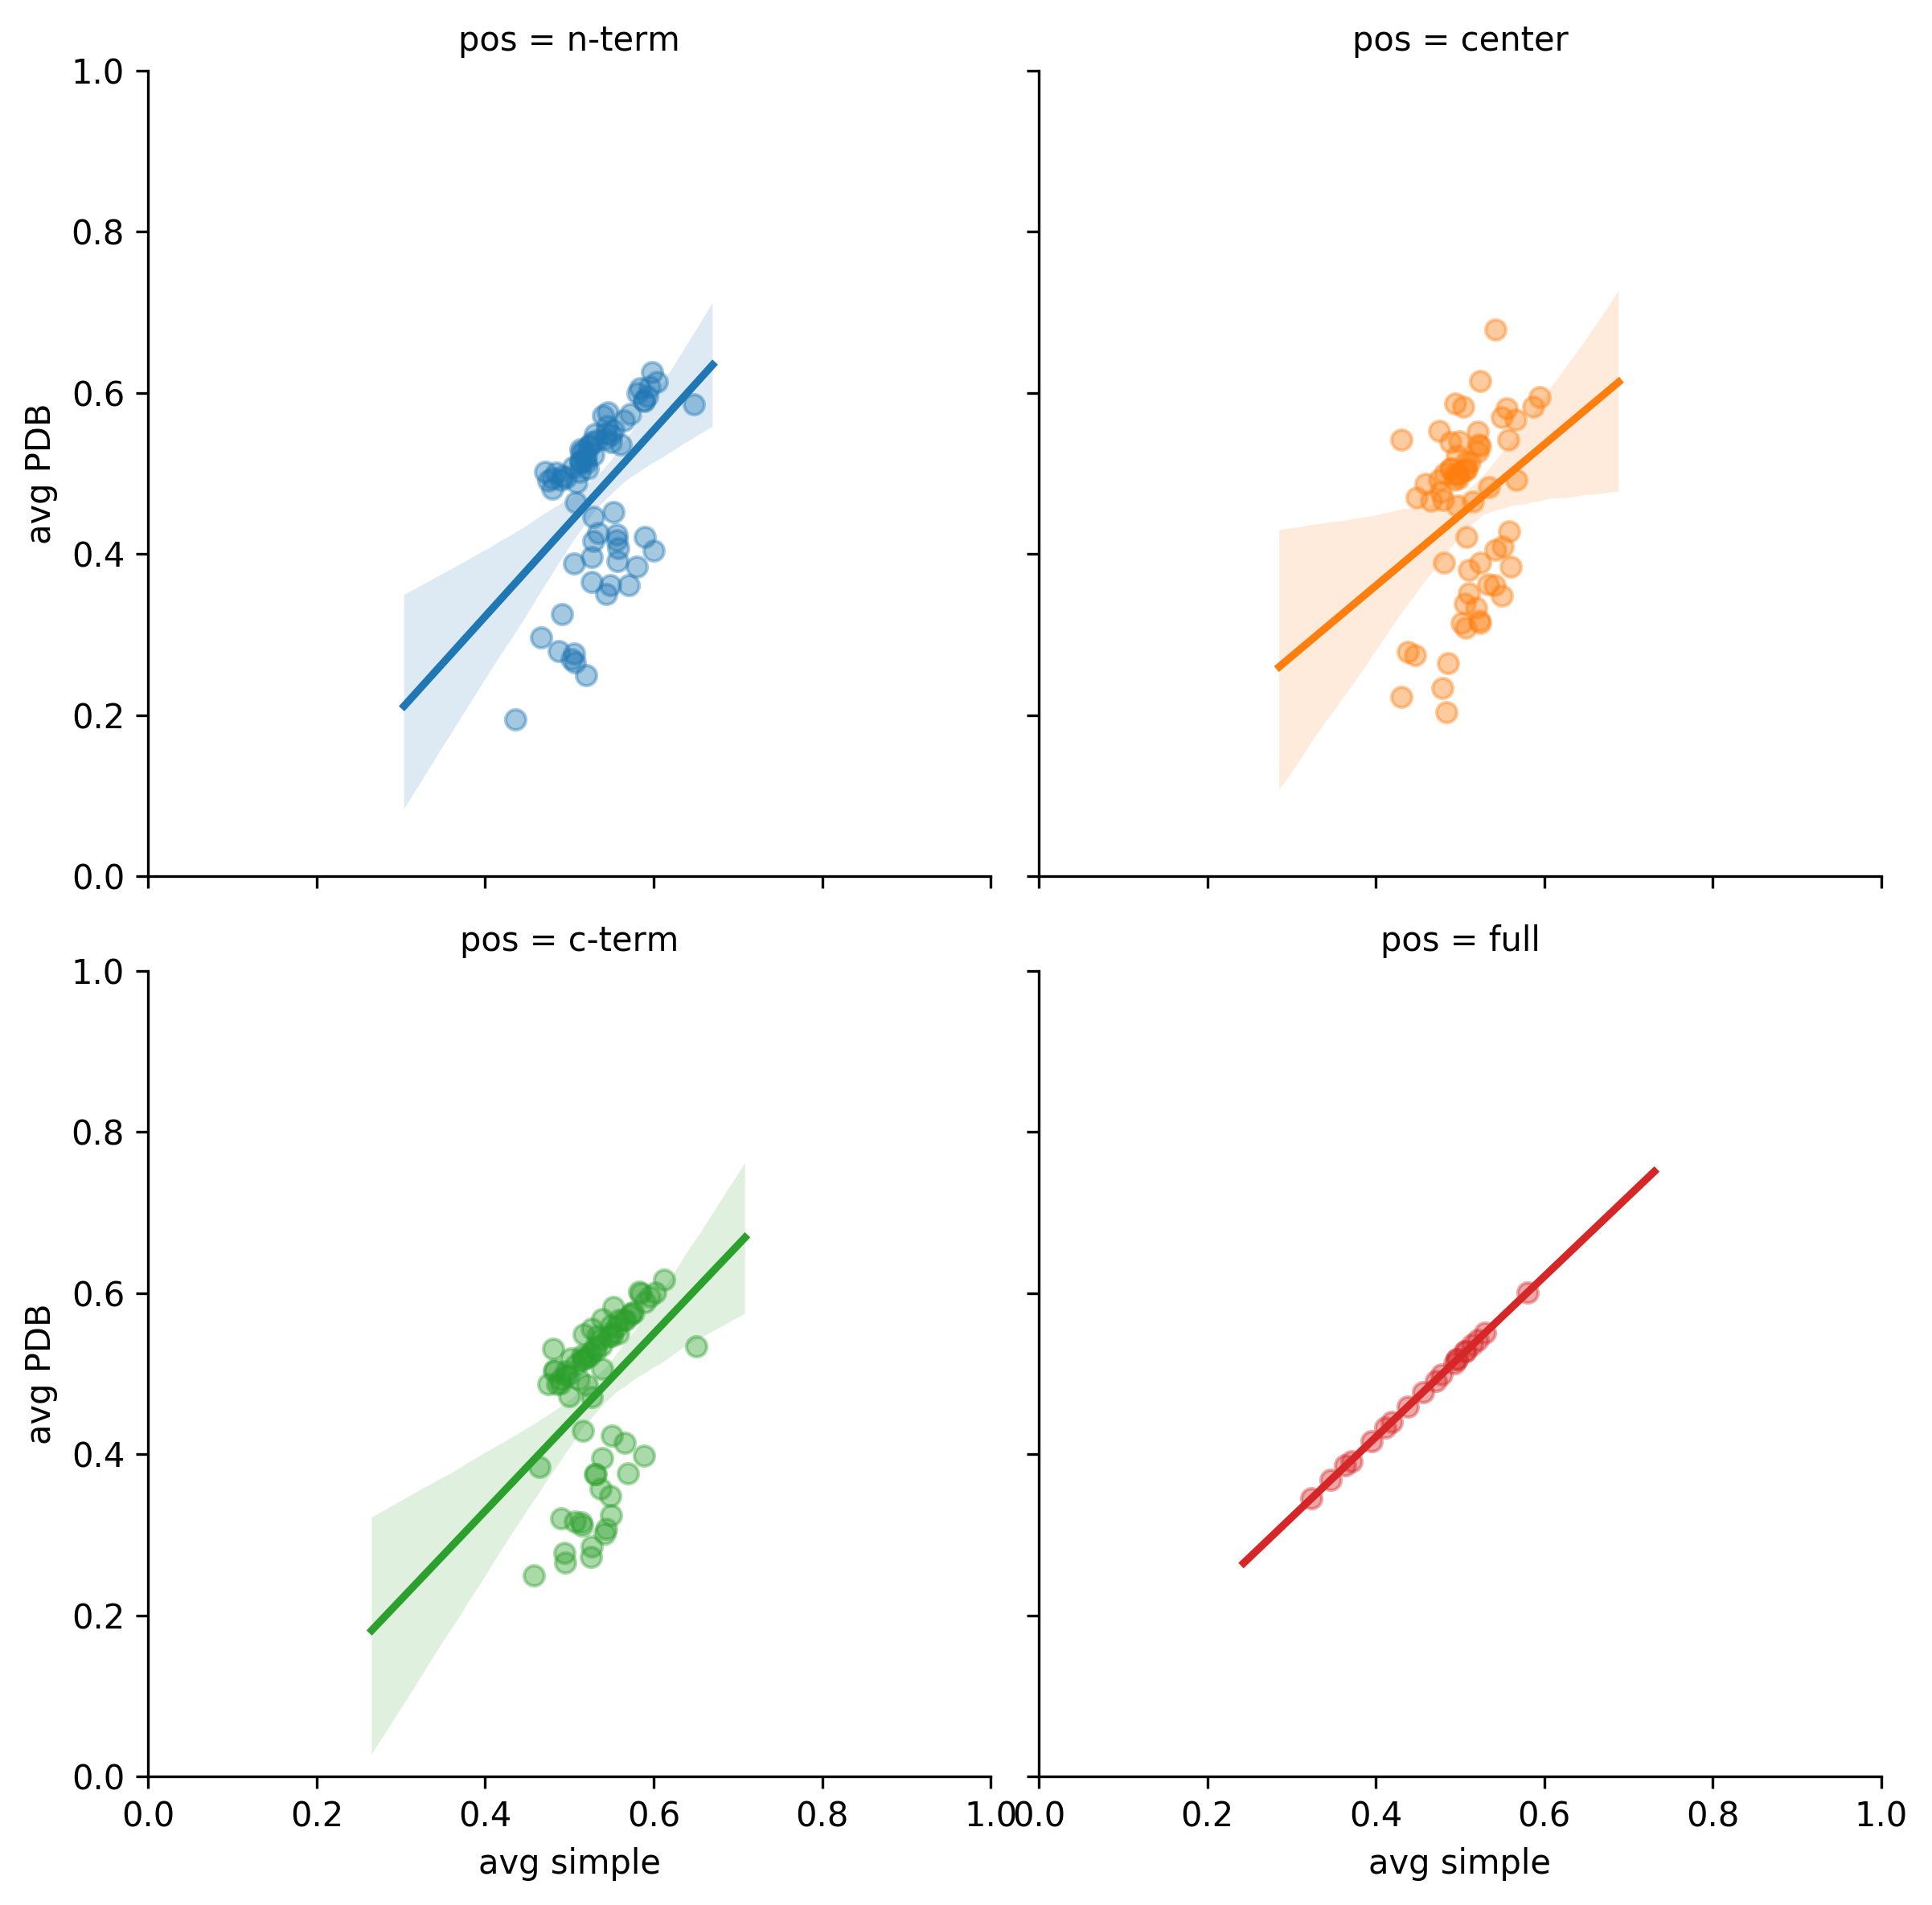

In [187]:
avg_acc = target_scores.xs('bal_acc', level=1)
t = pd.concat([avg_acc.mean(axis=0), avg_acc.std(axis=0)], axis=1,
              sort=False).rename(columns={
                  0: 'avg {}'.format(negatives),
                  1: 'std {}'.format(negatives)
              })

negs2 = 'pdb'
target_scores2 = merge_targets_tables(reference, negs2, baseline_dir,
                                      results_dir, thr_optimization)
avg_acc2 = target_scores2.xs('bal_acc', level=1)
t2 = pd.concat(
    [avg_acc2.mean(axis=0), avg_acc2.std(axis=0)], axis=1,
    sort=False).rename(columns={
        0: 'avg {}'.format(negs2.upper()),
        1: 'std {}'.format(negs2.upper())
    })

tt = pd.concat([t, t2], axis=1, sort=False)
tt['pos'] = pos

g = sns.lmplot(data=tt,
               x='avg {}'.format(negatives),
               y='avg {}'.format(negs2.upper()),
               hue='pos',
               col='pos',
               col_wrap=2,
               height=4,
               scatter_kws=dict(alpha=0.4))
g.set(ylim=(0, 1))
g.set(xlim=(0, 1));

Average balanced accuracy for targets with reference negative defined by the *simple* rule on $x$ axis. Average balanced accuracy for targets with reference negative defined by the *pdb* rule on $y$ axis. Each panel includes only targets with a specific average disorder position (C-terminal, N-Terminal, central, full-disorder)

## Consensus 
Consensus among all prediction methods was calculated as the fraction of positive predictions per residue.

In [188]:
consensus = pd.read_csv(get_fname(reference, negatives, results_dir,
                                  'consensusCM'),
                        index_col=[0])
consensus_cm = consensus[consensus.columns] / consensus.iloc[1].sum().round(
    2) * 100
consensus_cm[['tn', 'fp']] *= -1

consensus['fpr'] = consensus['fp'] / (consensus['fp'] + consensus['tn'])
consensus['tpr'] = consensus['tp'] / (consensus['tp'] + consensus['fn'])
consensus['fnr'] = 1 - consensus['tpr']
consensus['tnr'] = 1 - consensus['fpr']

minfpr = consensus['fpr'][consensus['fpr'] < 0.05].sort_values().tail(1)
minfpr_idx, minfpr_value = minfpr.index.item(), minfpr.item()
minfnr = consensus['fnr'][consensus['fnr'] < 0.05].sort_values().tail(1)
minfnr_idx, minfnr_value = minfnr.index.item(), minfnr.item()

### Confusion matrix per threshold
Predicted and actual positive and negatives for each threshold on the consensus score.

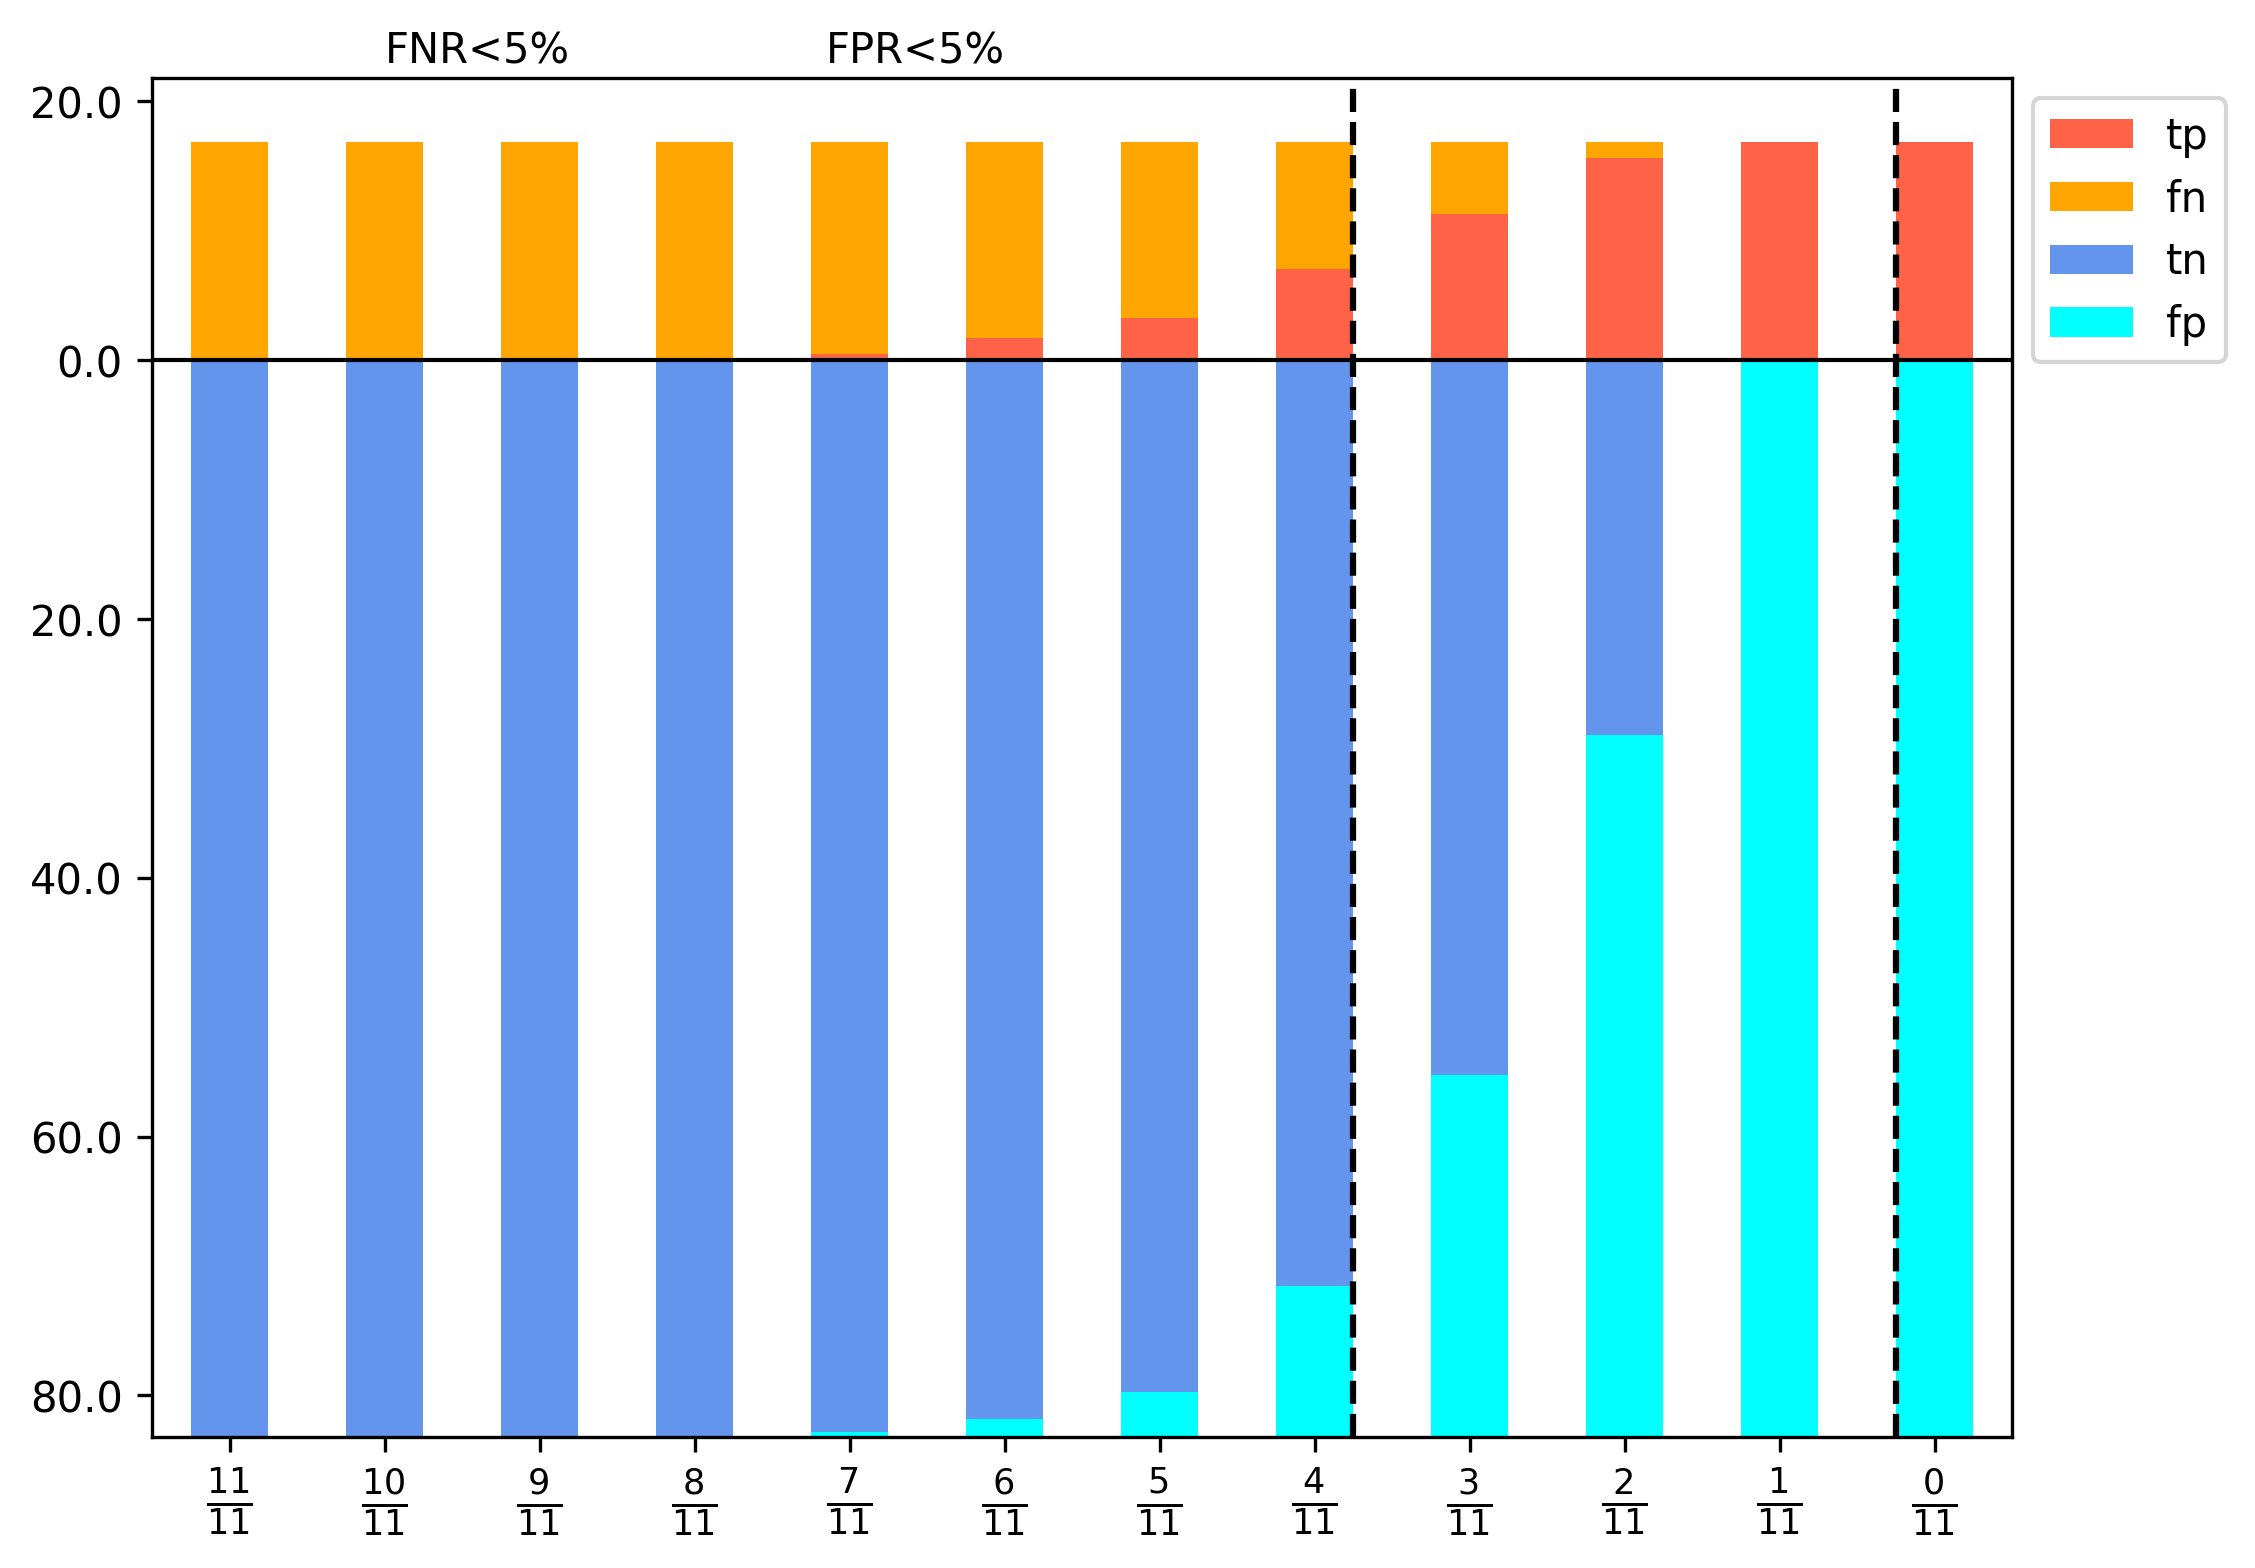

In [189]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = consensus_cm[['tp', 'fn', 'tn',
                   'fp']].sort_index(ascending=False).plot.bar(
                       stacked=True,
                       ax=ax,
                       color=['tomato', 'orange', 'cornflowerblue', 'cyan'])

ax.set_yticklabels(map(abs, ax.get_yticks()))
ax.set_xticklabels([
    r'$\frac{{{}}}{{{}}}$'.format(l.get_text(),
                                  len(consensus_cm) - 1)
    for l in ax.get_xticklabels()
])
ax.tick_params(axis='x', which='both', rotation=0, labelsize=12)
ax.axhline(0, c='k', linewidth=1)

topplot = round(ax.get_ylim()[-1]) + 1
ax.axvline(len(consensus) - minfpr_idx + 0.25,
           linestyle='--',
           linewidth=1.5,
           c='k')
ax.axvline(len(consensus) - minfnr_idx - 0.25,
           linestyle='--',
           linewidth=1.5,
           c='k')
ax.text(minfpr_idx, topplot, 'FPR<5%', horizontalalignment='right')
ax.text(minfnr_idx, topplot, 'FNR<5%')
ax.legend(bbox_to_anchor=(1, 1));

Percentage of correct and wrong assignment of positives (above $0$) and negatives (below $0$) for each threshold of the consensus.

### Accuracy per threshold
Balanced accuracy score for each threshold of the consensus.

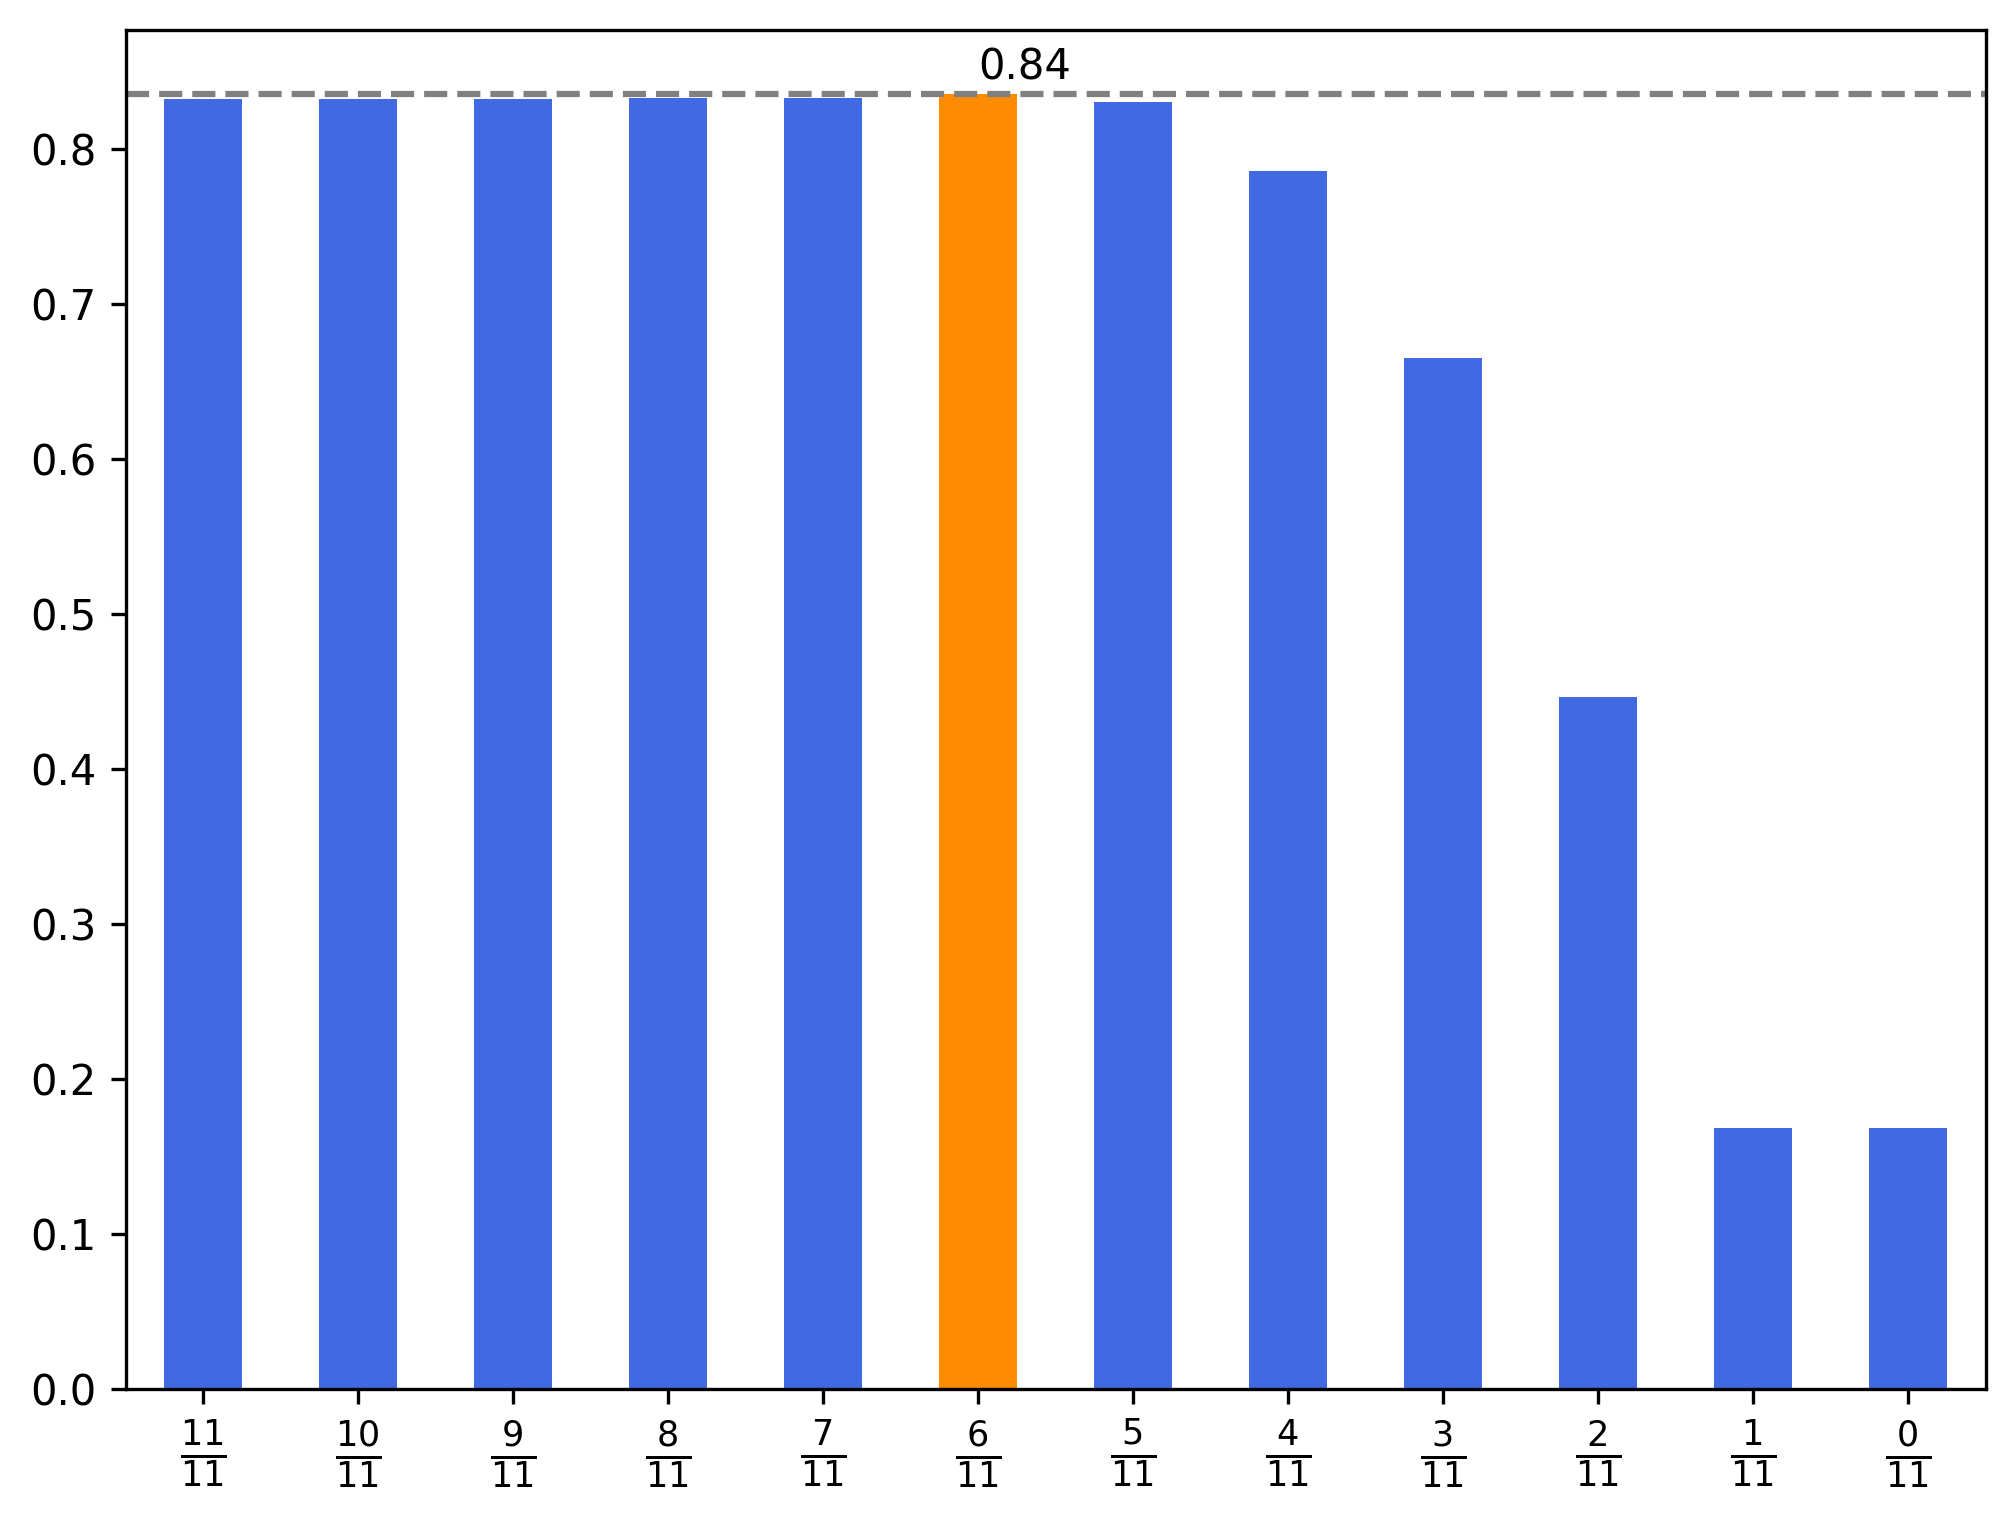

In [190]:
fig, ax = plt.subplots(figsize=(8, 6))

consensus_acc = abs(consensus_cm.sort_index(
    ascending=False)).apply(lambda s: (s['tp'] + s['tn']) / sum(s),
                            axis=1).rename(columns={0: 'Balanced Acc'})
colors = ["royalblue"] * len(consensus_acc)
colors[len(consensus_acc) -
       consensus_acc.sort_values(ascending=False).index[0] - 1] = "darkorange"
ax = consensus_acc.plot.bar(ax=ax, color=colors)
ax.set_xticklabels([
    r'$\frac{{{}}}{{{}}}$'.format(l.get_text(),
                                  len(consensus_cm) - 1)
    for l in ax.get_xticklabels()
])
ax.tick_params(axis='x', which='both', rotation=0, labelsize=12)
maxacc = consensus_acc.max()
ax.axhline(maxacc, c='grey', linestyle='--')
ax.text(
    len(consensus_acc) - consensus_acc.sort_values(ascending=False).index[0] -
    1, maxacc + 0.01, round(maxacc, 2));

Accuracy distribution for each consensus threshold. Bar of max threshold is highlighted in orange.

### Percentage of correct/incorrect classifications (missing)
Percentage of correct and incorrect classifications for nositives (defined by DisProt), negatives (defined by PDB) and undefined residues for each predictor.

In [191]:
# nopdb = pd.read_csv(get_fname(reference, 'simple-nopdb', results_dir,
#                               'scores'),
#                     index_col=[0])
# pdb = pd.read_csv(get_fname(reference, 'pdb', results_dir, 'scores'),
#                   index_col=[0])

# pos_cls = ['TP', 'FN']
# neg_cls = ['TN', 'FP']

# a = nopdb[pos_cls].T.set_index(
#     pd.MultiIndex.from_product([['DisProt'], pos_cls])).T
# b = pdb[neg_cls].T.set_index(pd.MultiIndex.from_product([['PDB'], neg_cls])).T
# c = nopdb[neg_cls].T.set_index(
#     pd.MultiIndex.from_product([['Undefined'], neg_cls])).T

# nopdb_cls = pd.concat([a, b, c], sort=False, axis=1).T.groupby(level=0).apply(
#     lambda g: g.apply(lambda s: s.apply(lambda x: x / s.sum()))).round(3) * 100
# nopdb_cls.T

### clustermap of binary predictions correlation 
Correlation of binary states between predictors.

In [192]:
tgt, preds = load_predstack(
    get_fname(reference, negatives, results_dir, 'predstack'))

In [193]:
pred_corr = pd.DataFrame(index=preds.keys(), columns=preds.keys())
pred_corr_pvals = pd.DataFrame(index=preds.keys(), columns=preds.keys())

for pi in preds:
    if '/' not in pi or pi.split('/')[0] in (str(minfpr_idx - 1),
                                             str(minfnr_idx - 1)):
        for pj in preds:
            if '/' not in pj or pj.split('/')[0] in (str(minfpr_idx),
                                                     str(minfnr_idx)):
                r, p = pearsonr(preds[pi], preds[pj])
                pred_corr.loc[pi][pj] = r
                pred_corr_pvals.loc[pi][pj] = p

/home/marnec/.local/share/virtualenvs/caid-ICjYQIts/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


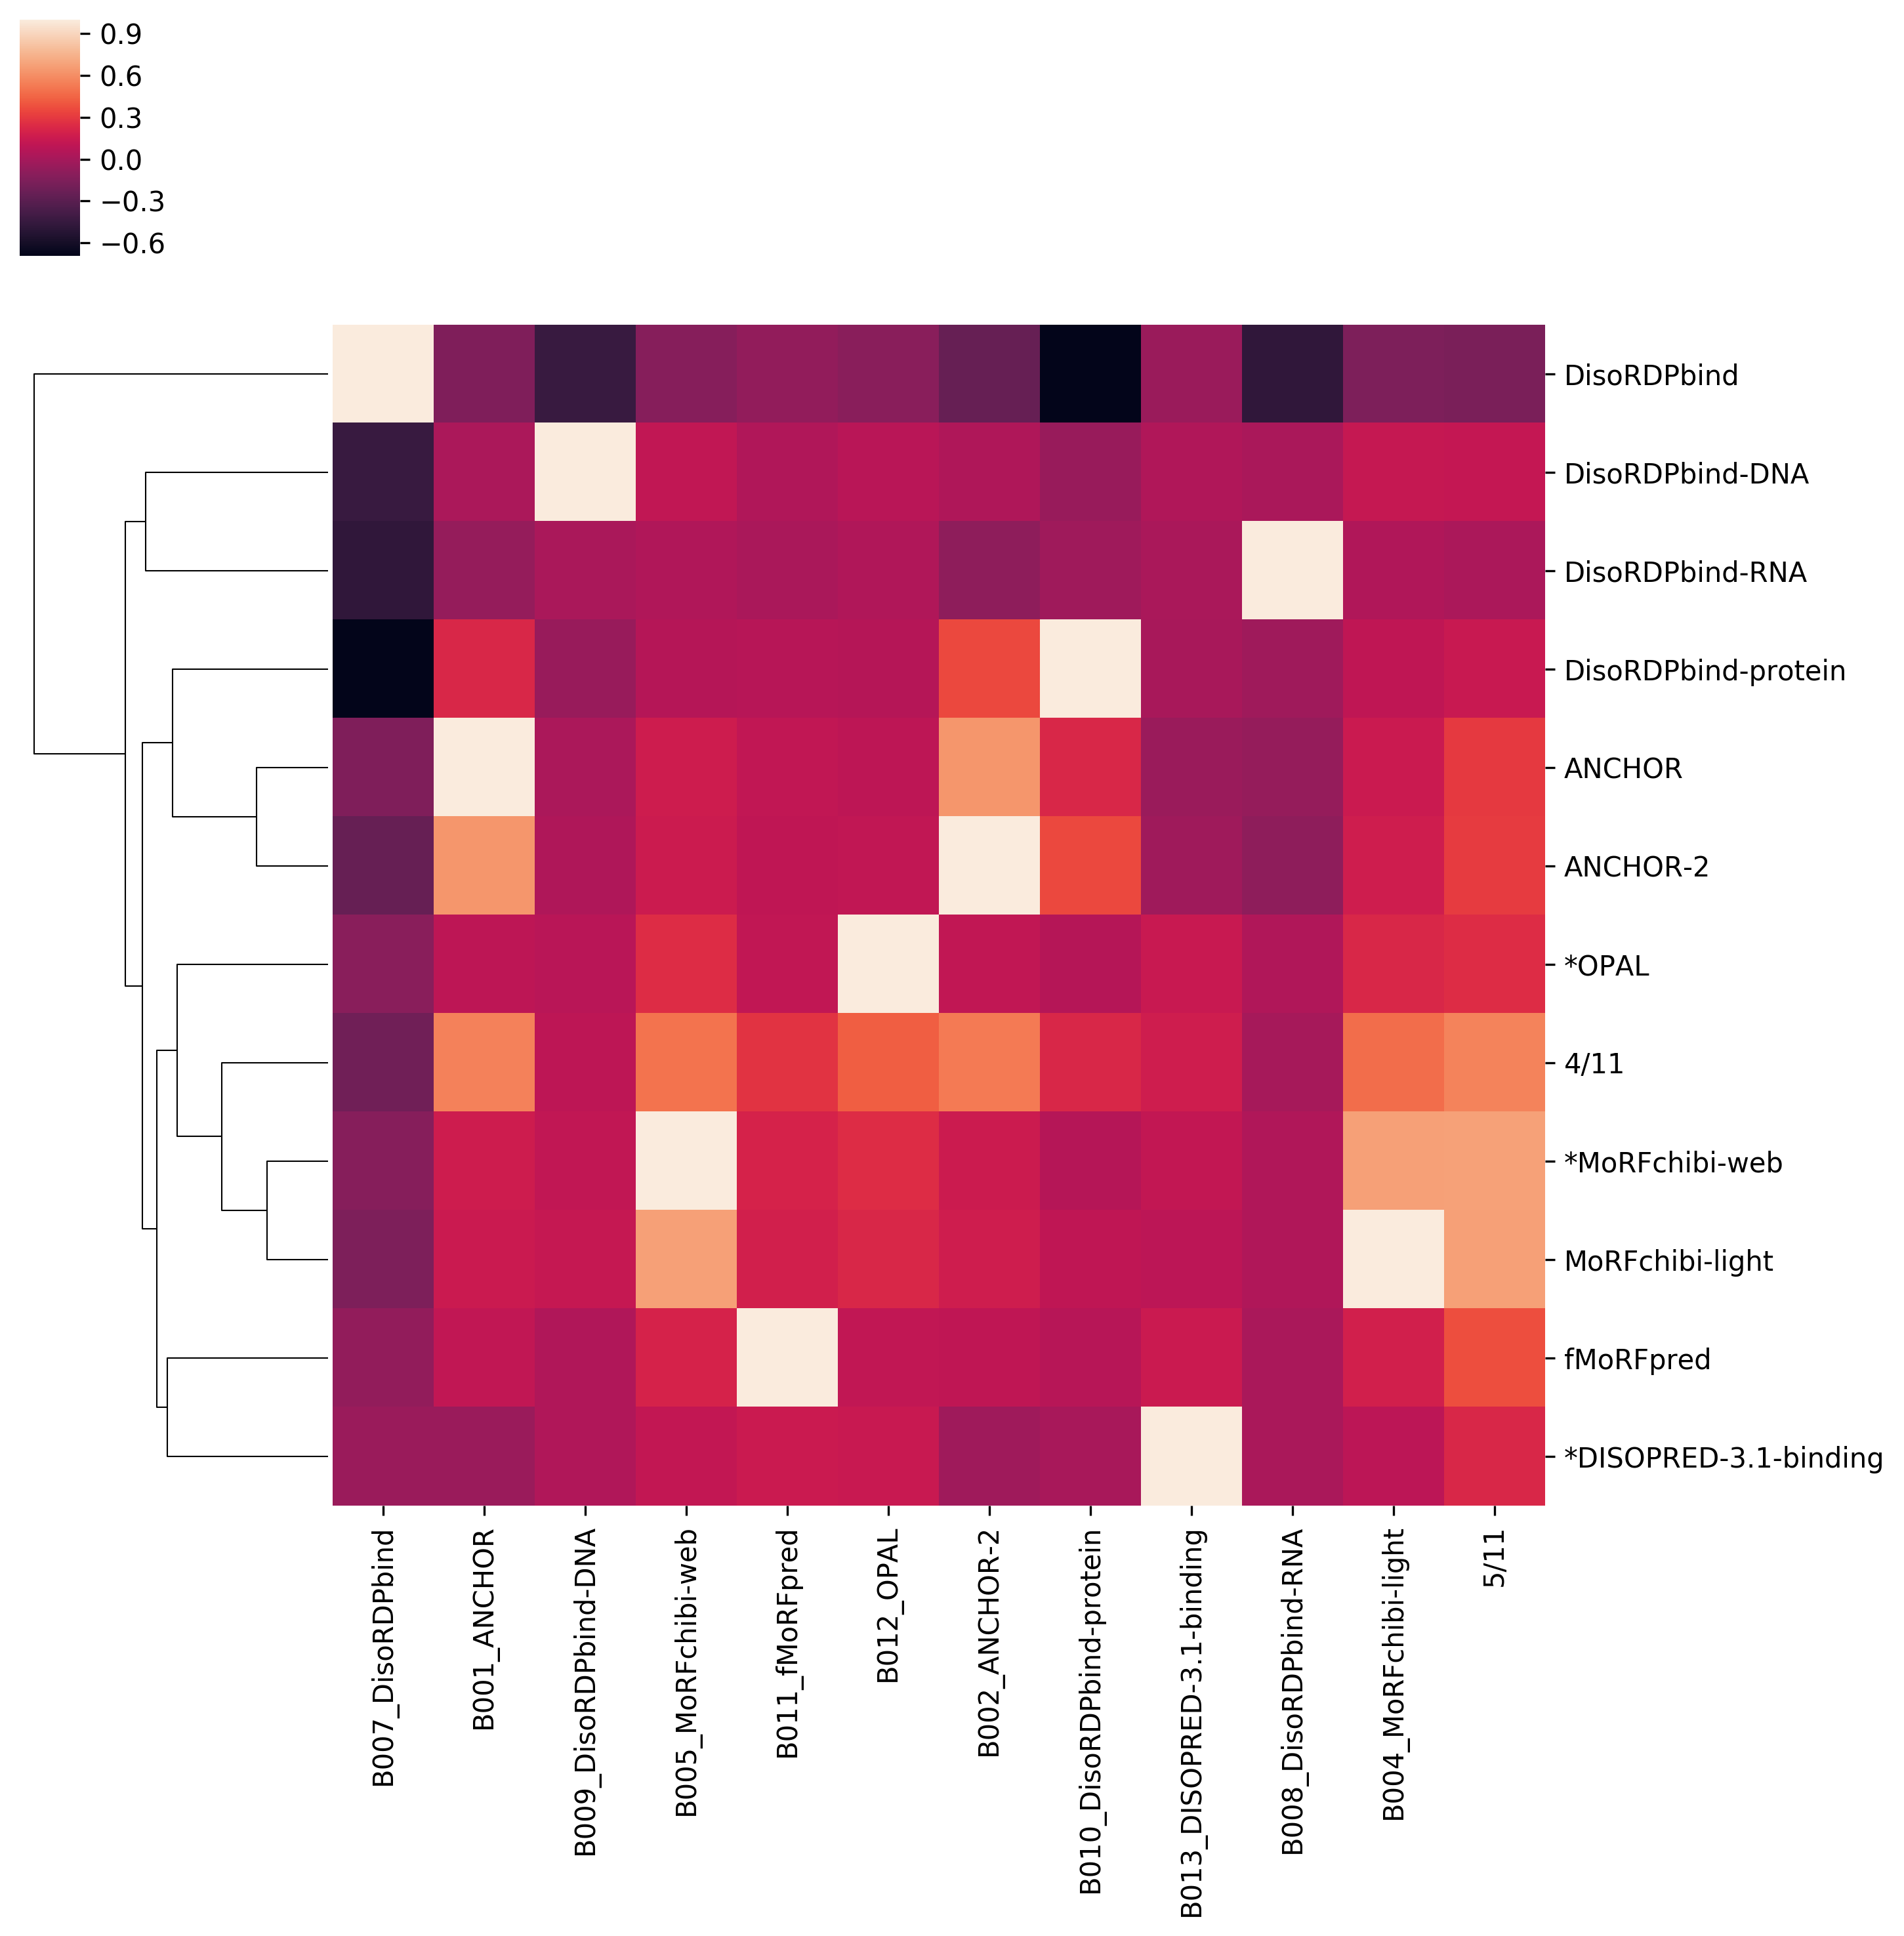

In [194]:
cax = sns.clustermap(pred_corr.dropna(0, how='all').dropna(
    1, how='all').astype(float).rename(index=labels_names),
                     col_cluster=None);

Heatmap of the correlation of binary prediction states for each couple of predictors. Pearson R is calculated between all predictions. Clustering is based on Euclidean distance calculated over an array (column) of R correlation coefficients.